In [1]:
import os
import zlib
from copy import deepcopy
from itertools import combinations
from random import *

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from numpy.linalg import *
from pylab import *
from pyentrp import entropy as ent
from scipy import signal
from scipy.io import loadmat, savemat
from scipy.signal import hilbert, resample
from scipy.stats import entropy, pearsonr, ranksums, ttest_ind, f_oneway
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.formula.api import ols

### Statistical Complexity

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### Lempel-Ziv

In [5]:
'''
Python code to compute LZc complexity measure as described in "Complexity of multi-dimensional spontaneous EEG decreases during propofol induced general anaesthesia"

Author: m.schartner@sussex.ac.uk
Date: 09.12.14

To compute Lempel-Ziv complexity for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########

def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])

 s=''
 for j in xrange(co):
  for i in xrange(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'

 return s

def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

## Analysis on Real Experimental Data ( Milan Sleep Data)

#### Step 1: Data Preprocessing

In [8]:
def load_and_downsample(filepath, target_freq=250):
    data = sio.loadmat(filepath)['dat']
    original_freq = 1000  # Hz
    downsample_factor = original_freq // target_freq
    downsampled_data = resample(data, data.shape[1] // downsample_factor, axis=1)
    return downsampled_data

# Example for loading and downsampling a specific file
filepath = 'C:/Users/odans/Documents/SUSSEX LAB WORKS/Dissertation Analysis/ba/E1000.mat'
downsampled_data = load_and_downsample(filepath)

#### Calculating the Downsampling Factor
The downsampling factor is calculated as:
\\[ \text{Downsampling Factor} = \frac{\text{Original Sampling Rate}}{\text{Target Sampling Rate}} = \frac{1000}{250} = 4 \\]

#### Applying the Downsampling
When the data is downsampled, the number of observations is reduced by the downsampling factor. This is shown below:

1. **Original Observations**: The original data for 'ba' has 910,000 observations.
2. **Target Observations**: After downsampling by a factor of 4, the number of observations is:
\\[ \text{Target Observations} = \frac{\text{Original Observations}}{\text{Downsampling Factor}} = \frac{910,000}{4} = 227,500 \\]

### Check

In [10]:
# Check the dimensions
original_data = sio.loadmat(filepath)['dat']
print(f"Original dimensions: {original_data.shape}")
print(f"Downsampled dimensions: {downsampled_data.shape}")

Original dimensions: (22, 910000)
Downsampled dimensions: (22, 227500)


This confirms that the data dimension reduces correctly after downsampling by a factor of 4.

#### Step 2: Complexity Measures Calculations

In [13]:
# Function to find state transitions in a binary string
def find_states(istring, dl, method="nonoverlapping"):
    i, output_dict = 0, {}
    if method == "nonoverlapping":
        # Non-overlapping sliding window approach
        while i + (dl * 2) <= len(istring):
            past, present = istring[i:i+dl], istring[i+dl:i+(2*dl)]
            if past not in output_dict:
                # Initialize state transition counts
                output_dict.update({past: {present: 1, "total": 1}})
            else:
                if present not in output_dict[past]:
                    output_dict[past].update({present: 1})
                else:
                    output_dict[past][present] += 1
                output_dict[past]["total"] += 1
            i += dl
    else:
        # Overlapping sliding window approach
        while i + dl + 1 <= len(istring):
            past, present = istring[i:i+dl], istring[i+1:i+1+dl]
            if past not in output_dict:
                output_dict.update({past: {present: 1, "total": 1}})
            else:
                if present not in output_dict[past]:
                    output_dict[past].update({present: 1})
                else:
                    output_dict[past][present] += 1
                output_dict[past]["total"] += 1
            i += 1
    try:
        # Handle the last state transition
        if method == "nonoverlapping":
            past, present = istring[i:i+dl], istring[i+dl:i+(2*dl)]
        else:
            past, present = istring[i:i+dl], istring[i+1:i+1+dl]
        if past not in output_dict:
            output_dict.update({past: {present: 1, "total": 1}})
        else:
            if present not in output_dict[past]:
                output_dict[past].update({present: 1})
            else:
                output_dict[past][present] += 1
            output_dict[past]["total"] += 1
    except:
        pass  # Ignore any errors due to reaching the end of the string
    
    # Normalize transition counts to probabilities
    for past in output_dict:
        for present in output_dict[past]:
            if present != "total":
                output_dict[past][present] /= output_dict[past]["total"]
    return output_dict

# Function to collapse similar states based on a threshold (sigma)
def collapse_states(odict, dl, sigma=0.1):
    newdict, temp, done_checker = deepcopy(odict), False, {}
    while True:
        if type(temp) != bool:
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if past1 not in done_checker:
                done_checker[past1] = {}
            for past2 in newdict:
                if past1 != past2:
                    if past2 not in done_checker[past1]:
                        done_checker[past1][past2] = True
                    else:
                        continue
                    # Merge states if their transition probabilities are similar
                    if calculate_difference(newdict[past1], newdict[past2]) < sigma:
                        temp = merge_states(newdict, past1, past2, dl)
                        break
            if type(temp) != bool:
                break
        if type(temp) == bool:
            break
    return newdict

# Function to calculate the difference between state transition probabilities
def calculate_difference(past1, past2):
    difference = -np.inf
    for present in past1:
        if present != "total":
            if present not in past2:
                difference = max(difference, past1[present])
            else:
                difference = max(difference, abs(past1[present] - past2[present]))
    for present in past2:
        if present != "total":
            if present not in past1:
                difference = max(difference, past2[present])
    return difference

# Function to merge two similar states
def merge_states(odict, past1, past2, dl):
    nprobs = {}
    for present in odict[past1]:
        if present in odict[past2]:
            nprobs.update({present: (odict[past1][present] + odict[past2][present]) / 2})
        else:
            nprobs.update({present: odict[past1][present] / 2})
    for present in odict[past2]:
        if present not in odict[past1]:
            nprobs.update({present: odict[past2][present] / 2})
    nprobs.update({"total": odict[past1]["total"] + odict[past2]["total"]})
    
    # Create a new key by sorting and combining the merged states
    temp, to_sort = past1 + past2, []
    for i in range(int(len(temp) / dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while len(to_sort) > 0:
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    
    # Update the dictionary with the merged state
    ndict = deepcopy(odict)
    ndict.update({newkey: nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

# Function to calculate the probability of each past state
def collapse_past(odict):
    probs, i, total = np.zeros(len(odict), dtype=float), 0, 0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i += 1
    return probs / total

# Function to calculate statistical complexity of a binary string
def calculate(istring, dl, sigma=0.05, method="overlapping", states_provided=False, return_states=False):
    if type(states_provided) == bool:
        # Find and refine states
        initial_states = find_states(istring, dl, method=method)
        refined_states = collapse_states(initial_states, dl, sigma)
    else:
        initial_states, refined_states = states_provided, states_provided
    
    # Calculate the probability distribution of past states
    probs = collapse_past(refined_states)
    logprobs = np.log2(probs)
    
    # Calculate the complexity (entropy)
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i] * logprobs[i]
    
    if return_states == False:
        return complexity
    else:
        return complexity, refined_states, initial_states

# Function to binarize the data based on a threshold (median or mean)
def binarise(data, mode="median"):
    if type(data) == list or type(data) == tuple:
        data = np.array(data, dtype=float)
    if isinstance(data, np.ndarray) == False:
        return "Unusable datatype {}".format(type(data))

    binarized_data = []
    for channel in data:
        if mode == "median":
            threshold = np.median(channel)
        elif mode == "mean":
            threshold = np.mean(channel)
        output = np.zeros(len(channel), dtype=int)
        output[channel >= threshold] = 1
        binarized_data.append("".join(map(str, output)))
    return "".join(binarized_data)

# Function to calculate Lempel-Ziv complexity for a binary string
def LZc_binary(string):
    # Helper function to calculate complexity
    def cpr(s):
        d = {}
        w = ''
        for c in s:
            wc = w + c
            if wc in d:
                w = wc
            else:
                d[wc] = wc
                w = c
        return len(d)
    
    # Shuffle the string for normalization
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity value
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity

# Function to apply complexity measures to the data
def apply_complexity_measures(data, segment_length=250):
    binarized_data = binarise(data)
    lz_complexity = LZc_binary(binarized_data)
    stat_diversity = calculate(binarized_data, dl=3, sigma=0.05)
    return lz_complexity, stat_diversity

# Example for a single participant
filepath = 'C:/Users/odans/Documents/SUSSEX LAB WORKS/Dissertation Analysis/ba/E1000.mat'
downsampled_data = load_and_downsample(filepath)

# Apply complexity measures to the downsampled data
lz_complexity, stat_diversity = apply_complexity_measures(downsampled_data)

# Print the results
print(f"Lempel-Ziv complexity: {lz_complexity}")
print(f"Statistical Diversity: {stat_diversity}")

Lempel-Ziv complexity: 0.19342972557465005
Statistical Diversity: 1.317878604902413


#### Step 3: Parameter Variation

In [15]:
def apply_complexity_measures_with_params(data, dl=3, sigma=0.05, segment_length=250):
    # Binarize the data
    binarized_data = binarise(data)
    
    # Calculate Lempel-Ziv complexity of the binarized data
    lz_complexity = LZc_binary(binarized_data)
    
    # Calculate statistical diversity with given parameters
    stat_diversity = calculate(binarized_data, dl=dl, sigma=sigma)
    
    # Return both complexity measures
    return lz_complexity, stat_diversity

def analyze_with_varied_parameters(base_path, participants, states, dls, sigmas, segment_lengths):
    results = {}
    
    # Iterate over each participant
    for participant in participants:
        results[participant] = {}
        
        # Iterate over each state
        for state in states:
            # Construct the file path for the current participant and state
            filepath = f"{base_path}/{participant}/{state}1000.mat"
            
            # Load and downsample the data from the file
            downsampled_data = load_and_downsample(filepath)
            results[participant][state] = {}
            
            # Iterate over each combination of dl, sigma, and segment length
            for dl in dls:
                for sigma in sigmas:
                    for segment_length in segment_lengths:
                        key = (dl, sigma, segment_length)
                        
                        # Truncate the data to the specified segment length
                        truncated_data = downsampled_data[:, :segment_length]
                        
                        # Apply complexity measures with the current parameters
                        lz_complexity, stat_diversity = apply_complexity_measures_with_params(truncated_data, dl=dl, sigma=sigma, segment_length=segment_length)
                        
                        # Store the results in the dictionary
                        results[participant][state][key] = (lz_complexity, stat_diversity)
    
    # Return the results dictionary
    return results

# Parameters to vary
dls = [3, 4, 5]
sigmas = [0.01, 0.05, 0.1]
segment_lengths = [1000, 2000, 3000]  # Example segment lengths in number of samples
base_path = 'C:/Users/odans/Documents/SUSSEX LAB WORKS/Dissertation Analysis'
participants = ['ba', 'fe', 'fr', 'gi', 'me', 'pa', 'pe', 'te', 'to', 'za']
states = ['L', 'E' , 'R', 'W']

# Example usage
results_varied_params = analyze_with_varied_parameters(base_path, participants, states, dls, sigmas, segment_lengths)

In [16]:
base_path = 'C:/Users/odans/Documents/SUSSEX LAB WORKS/Dissertation Analysis'
participants = ['ba', 'fe', 'fr', 'gi', 'me', 'pa', 'pe', 'te', 'to', 'za']
states = ['L', 'E' , 'R', 'W']

#### Step 4: Analyze and Visualize Results

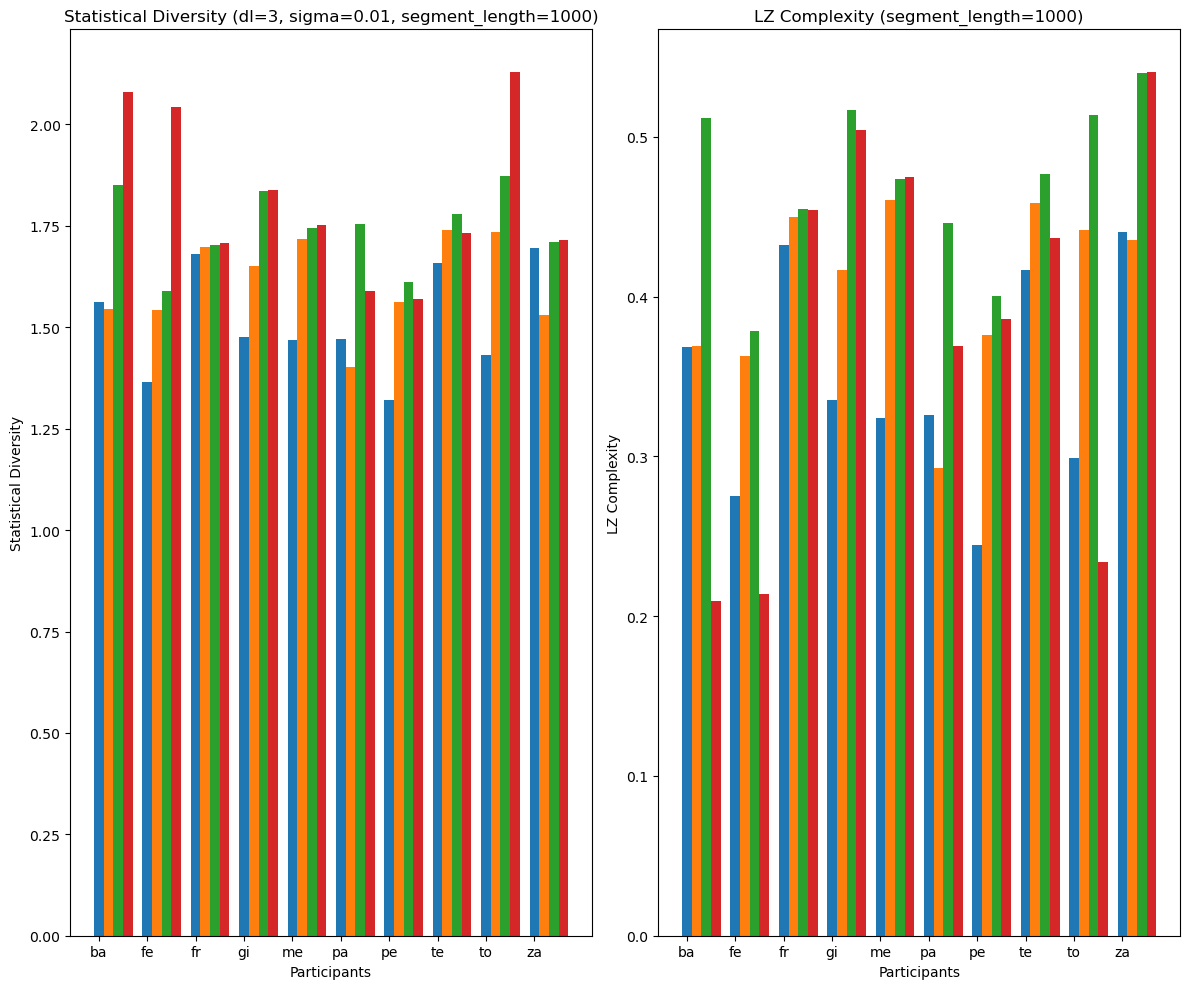

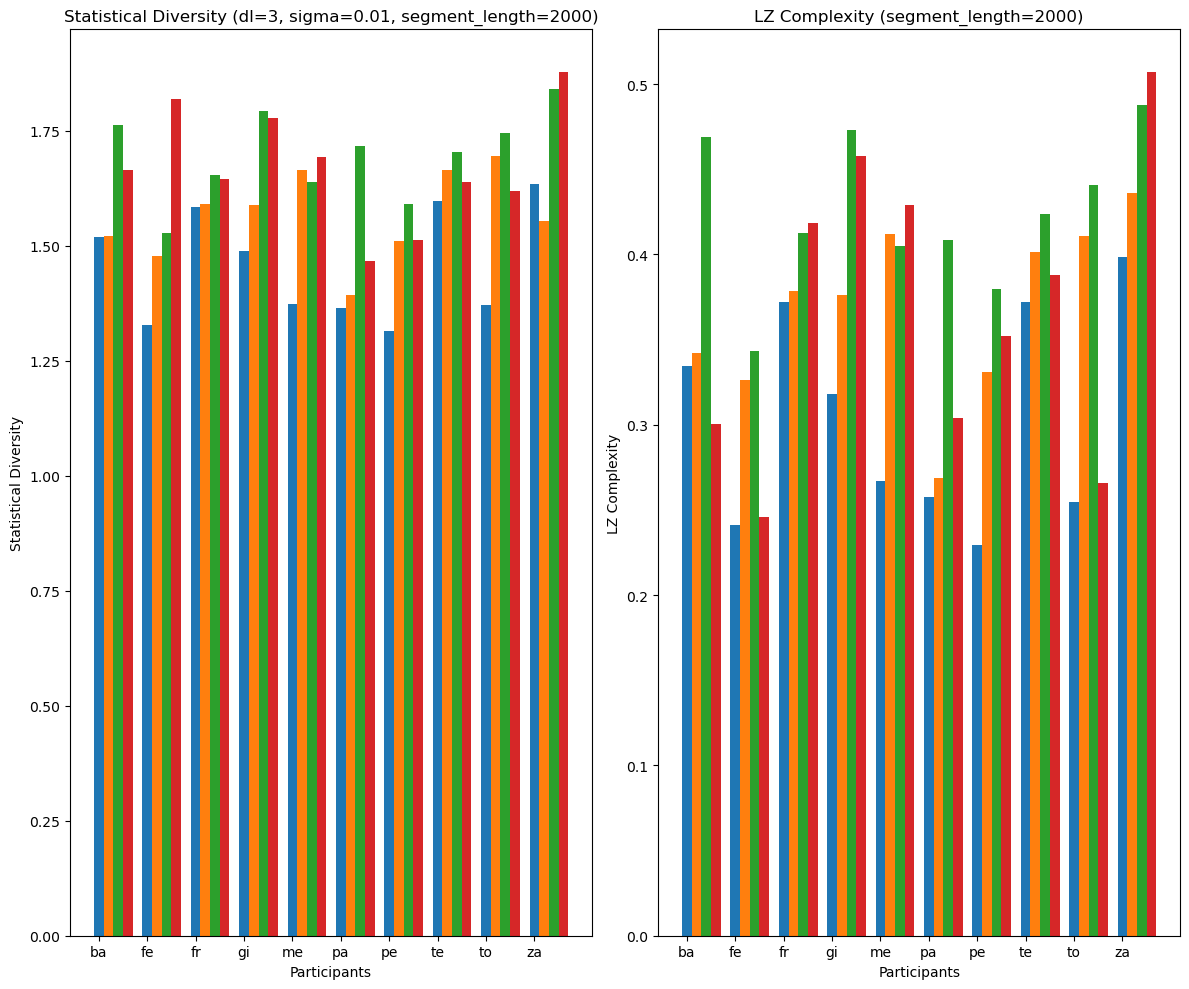

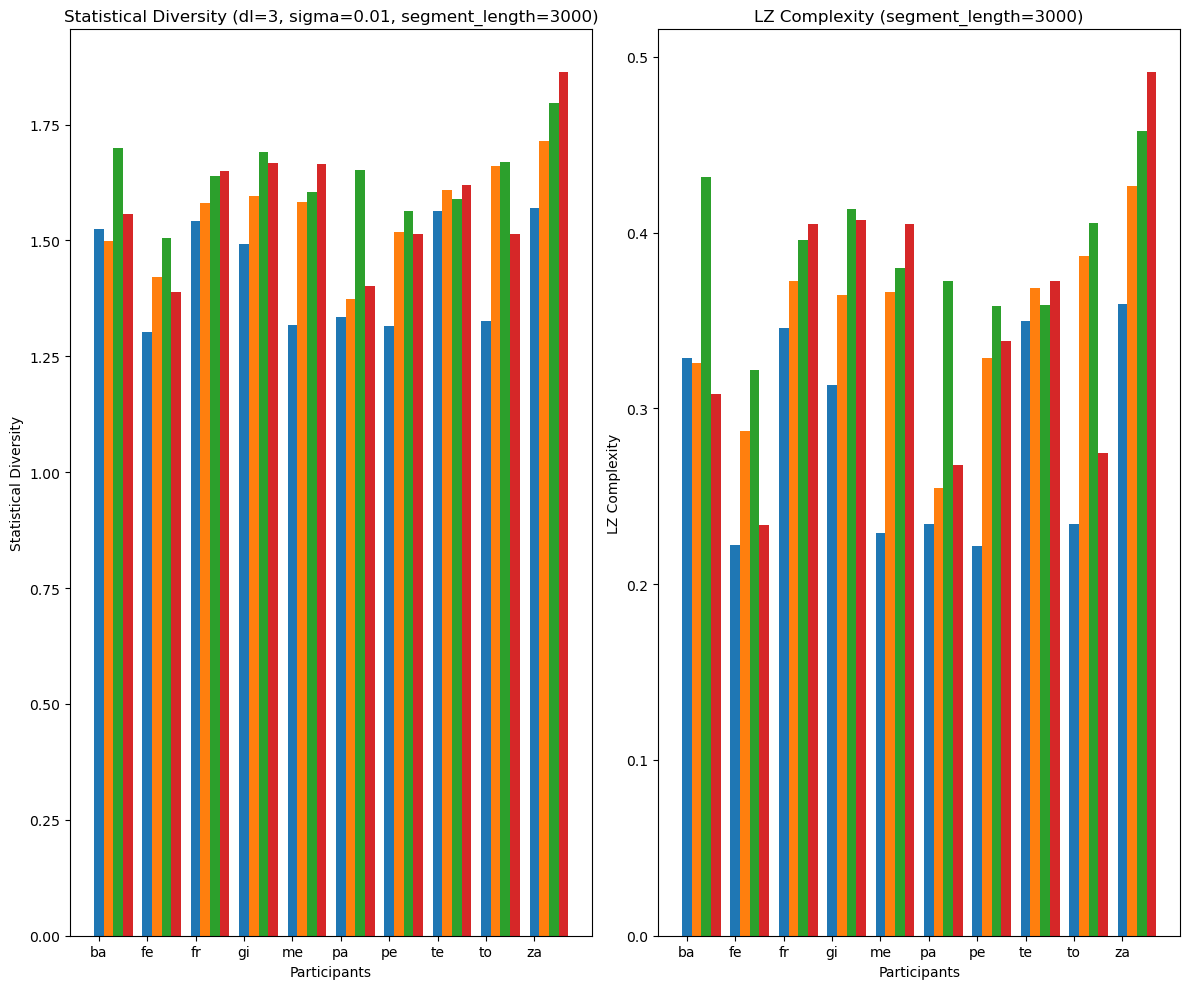

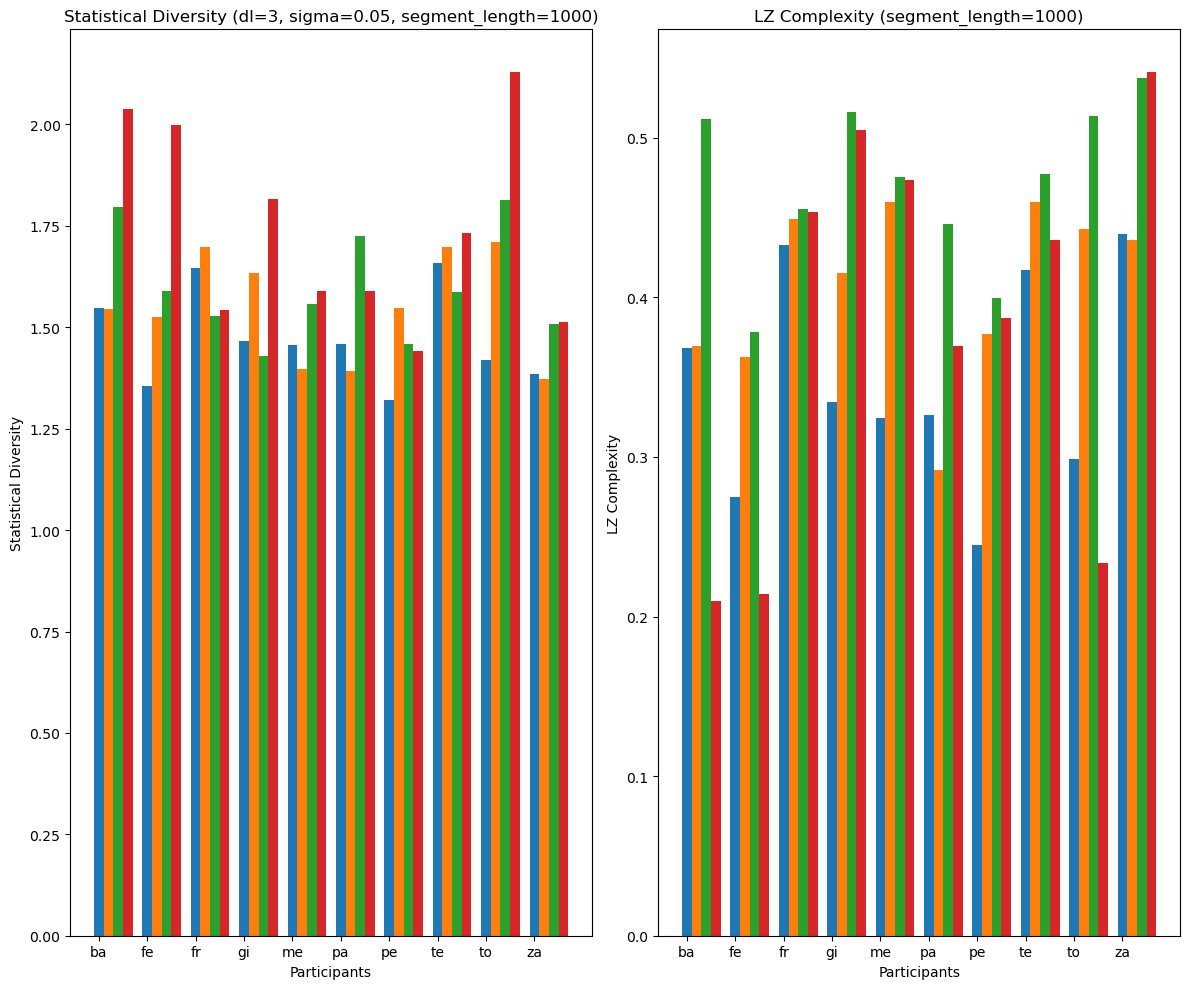

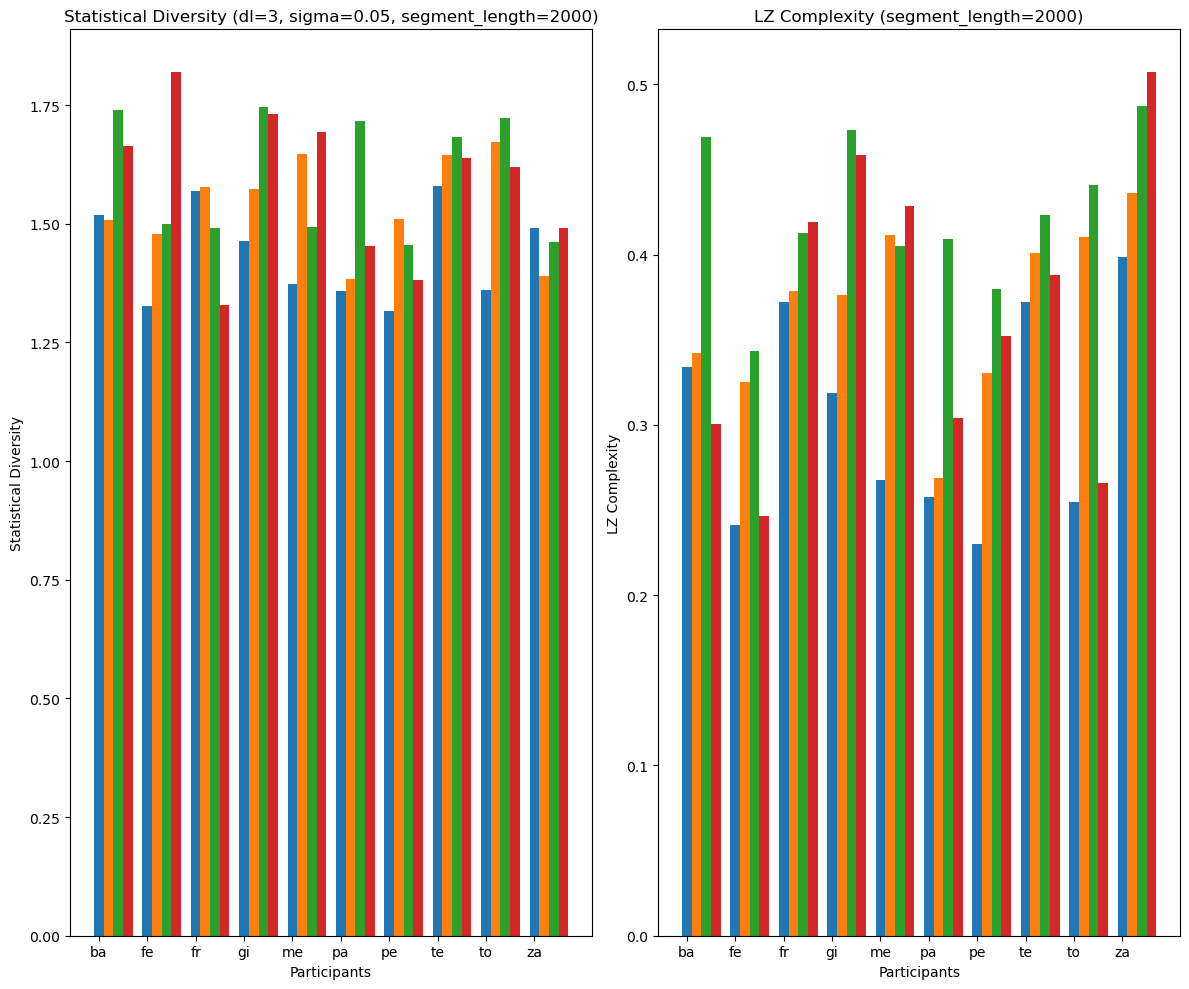

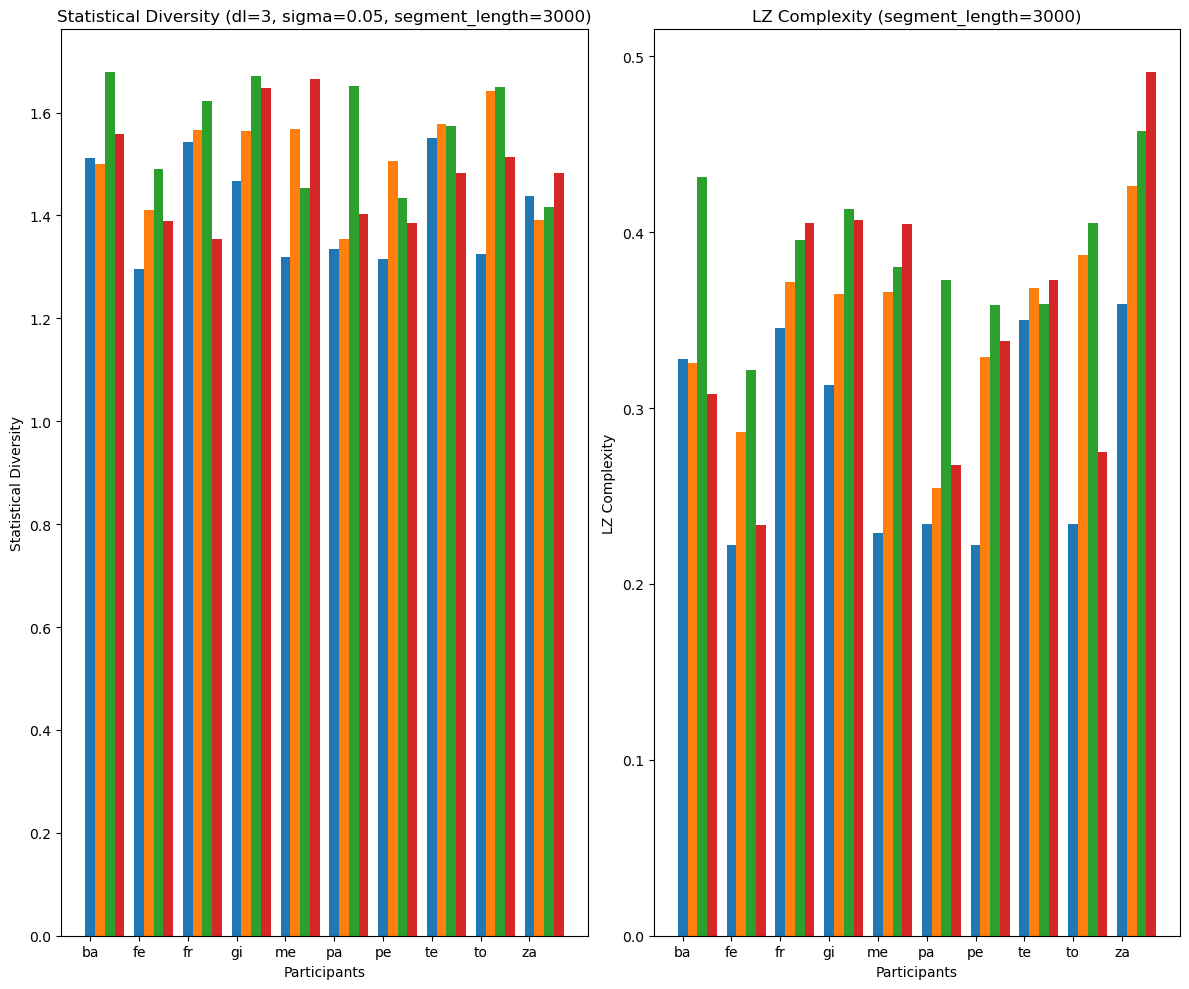

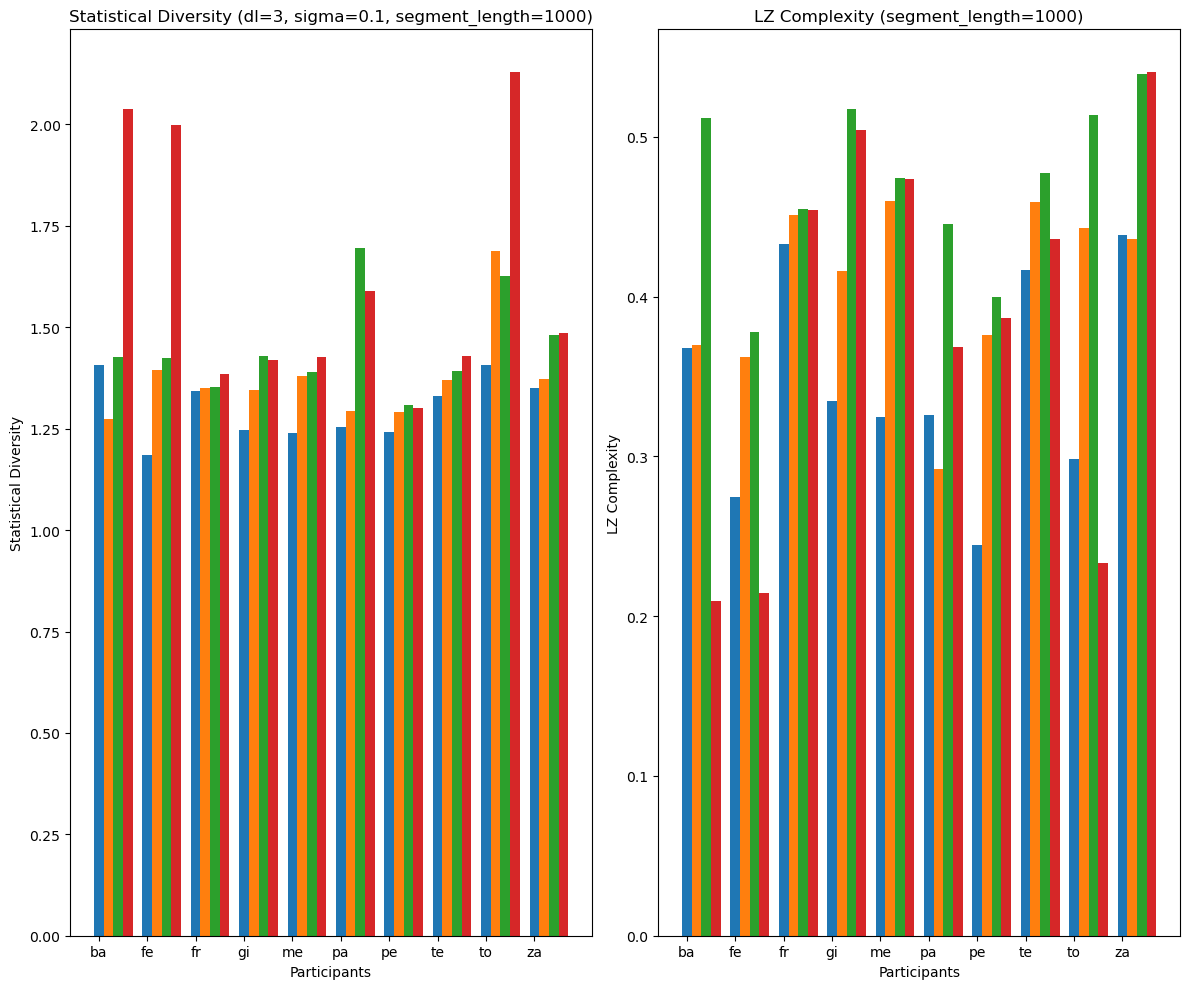

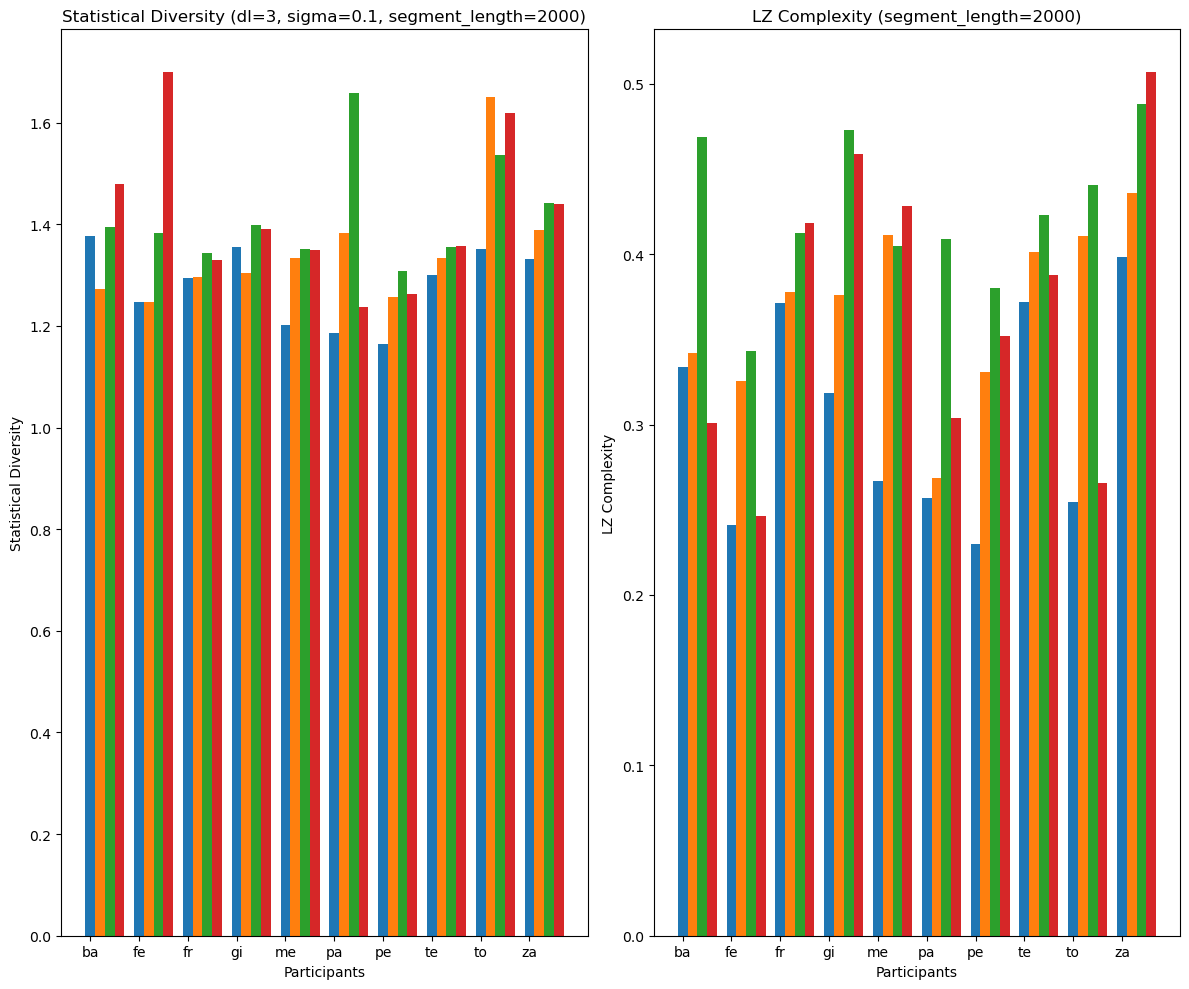

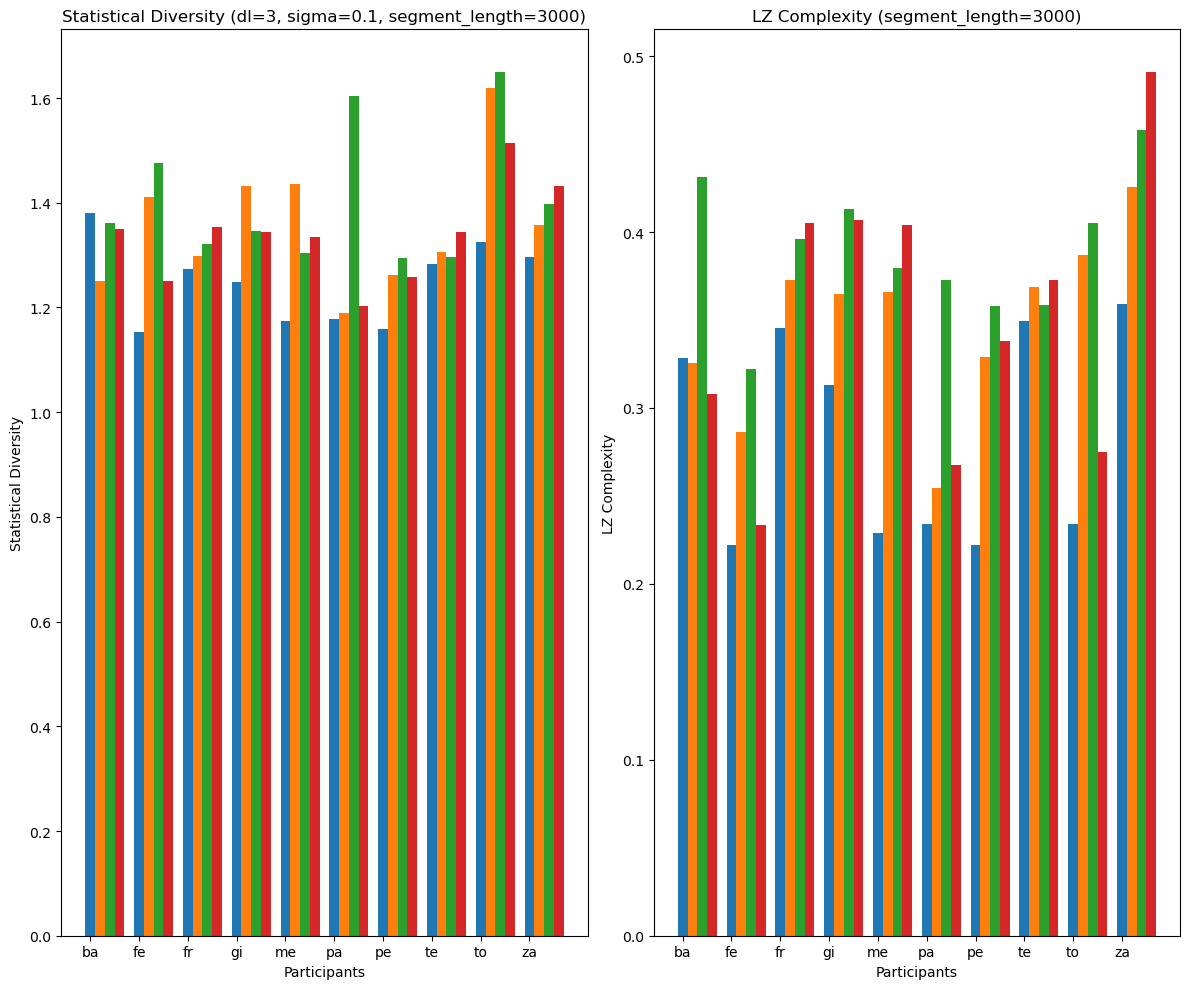

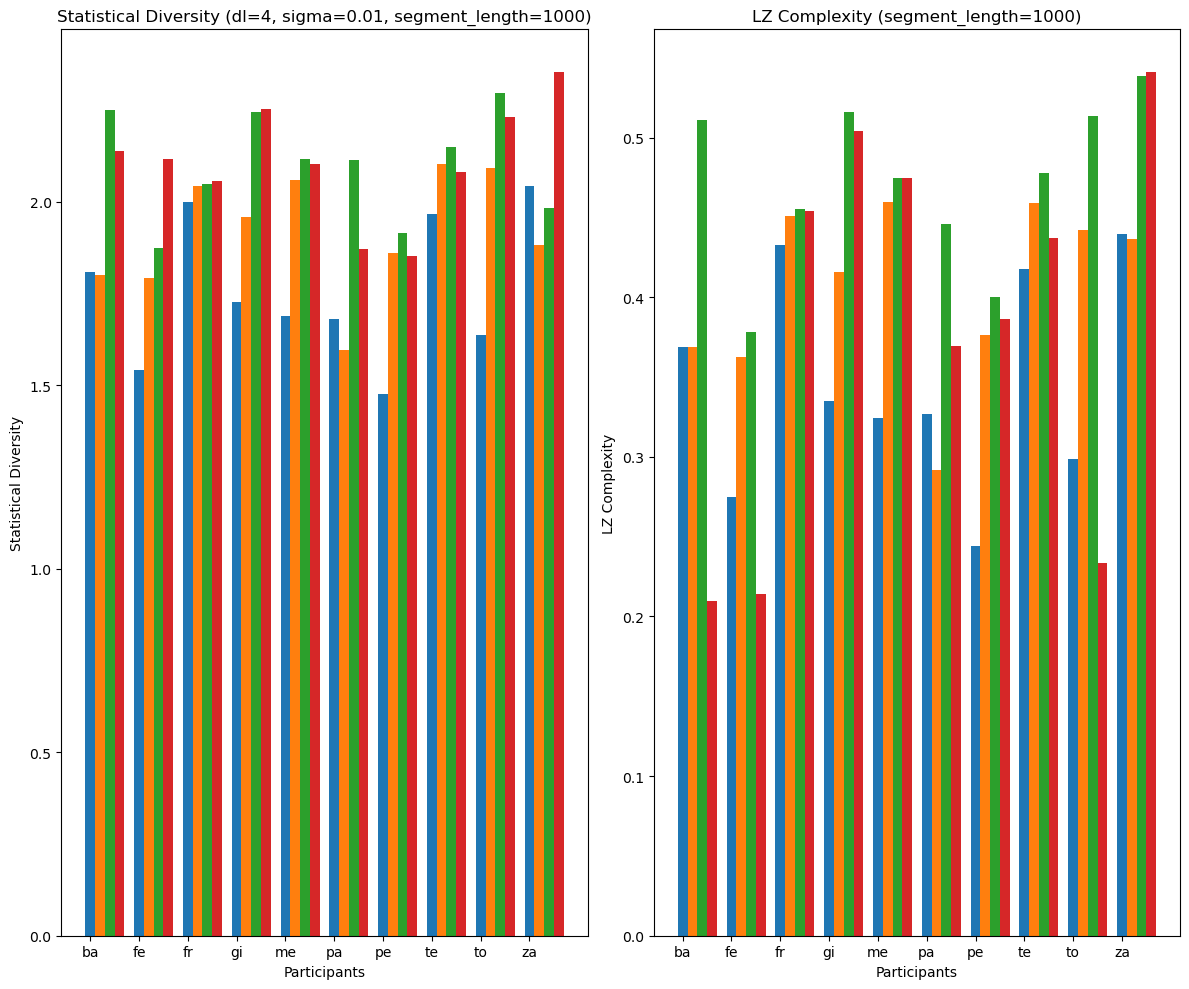

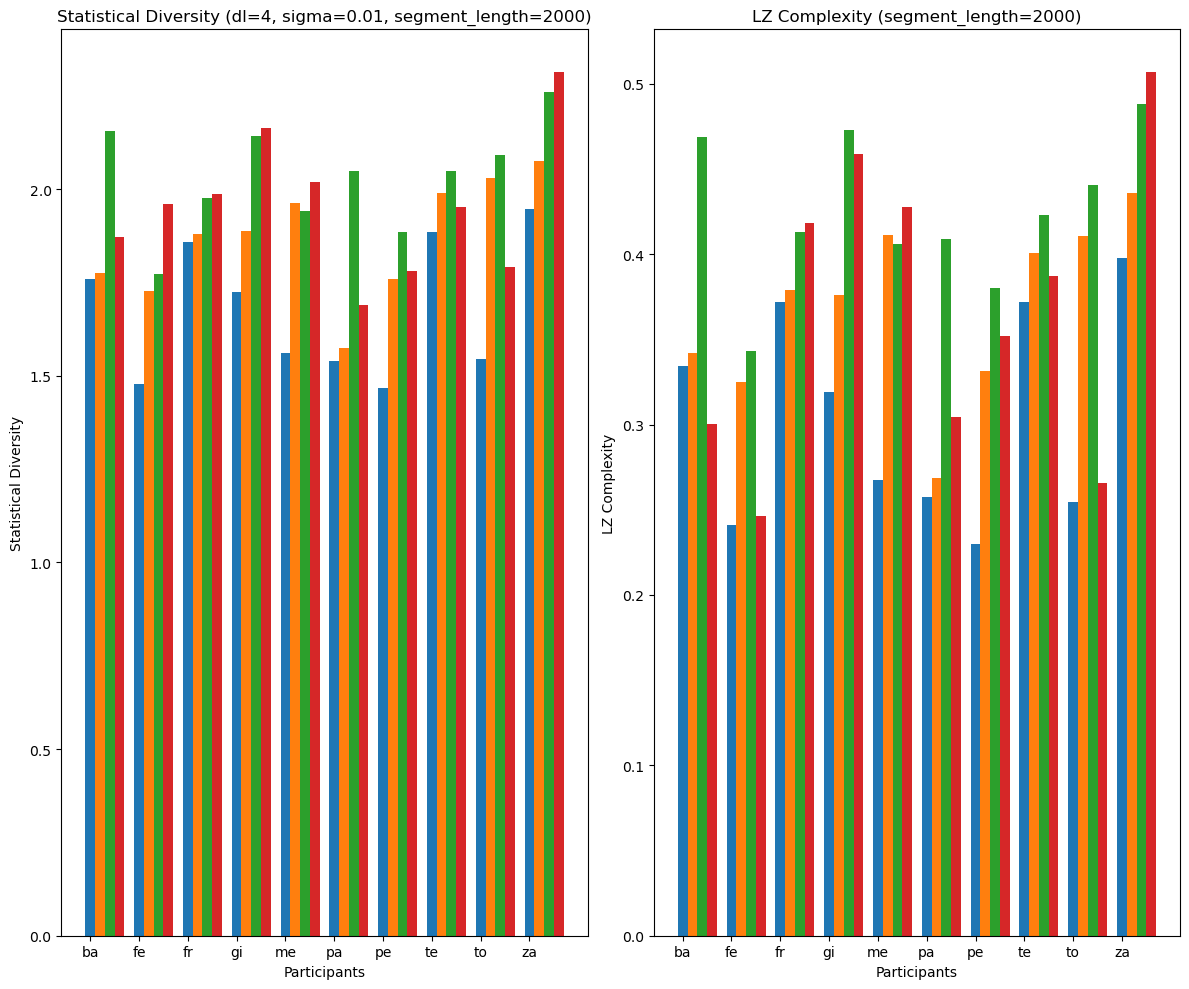

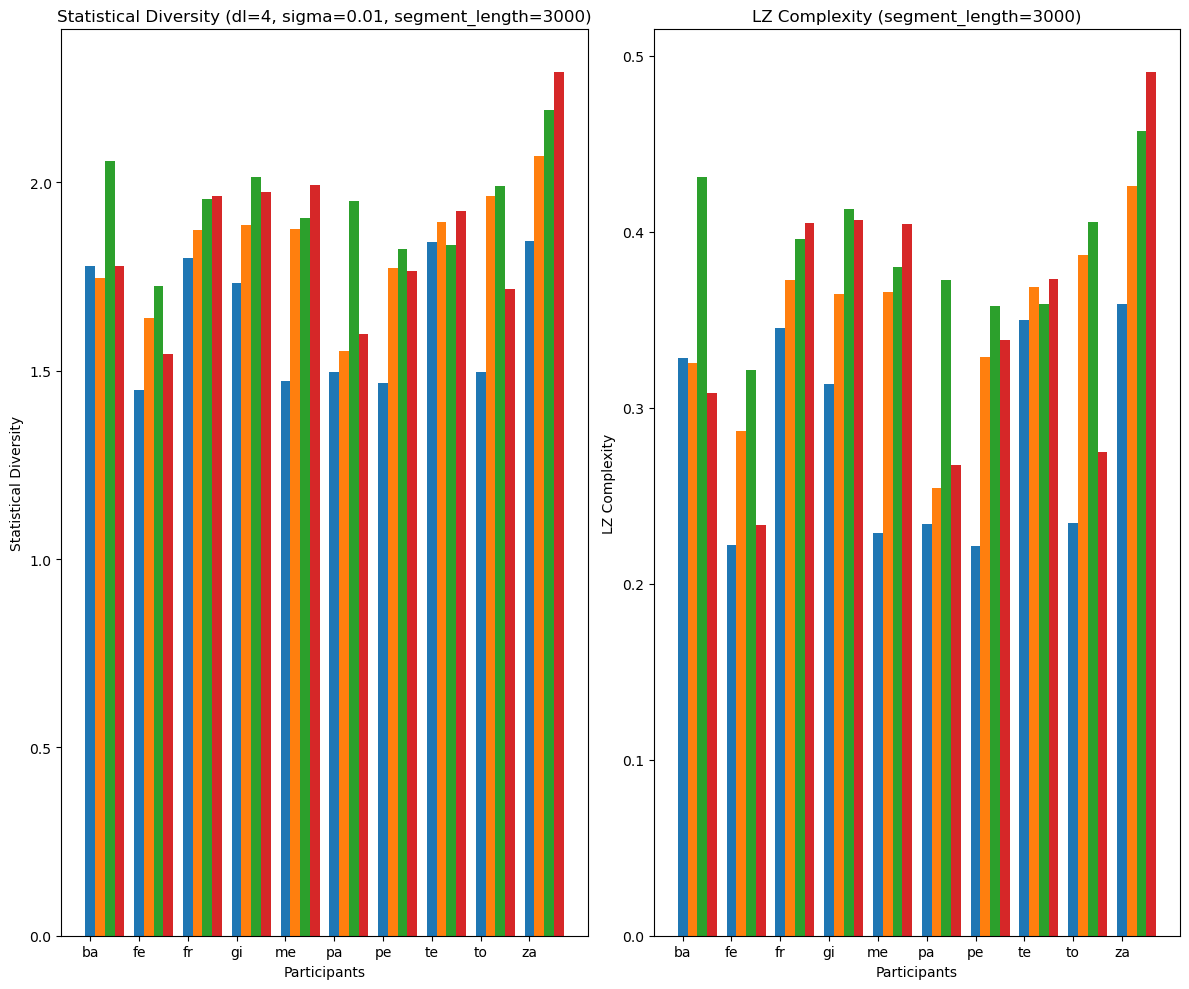

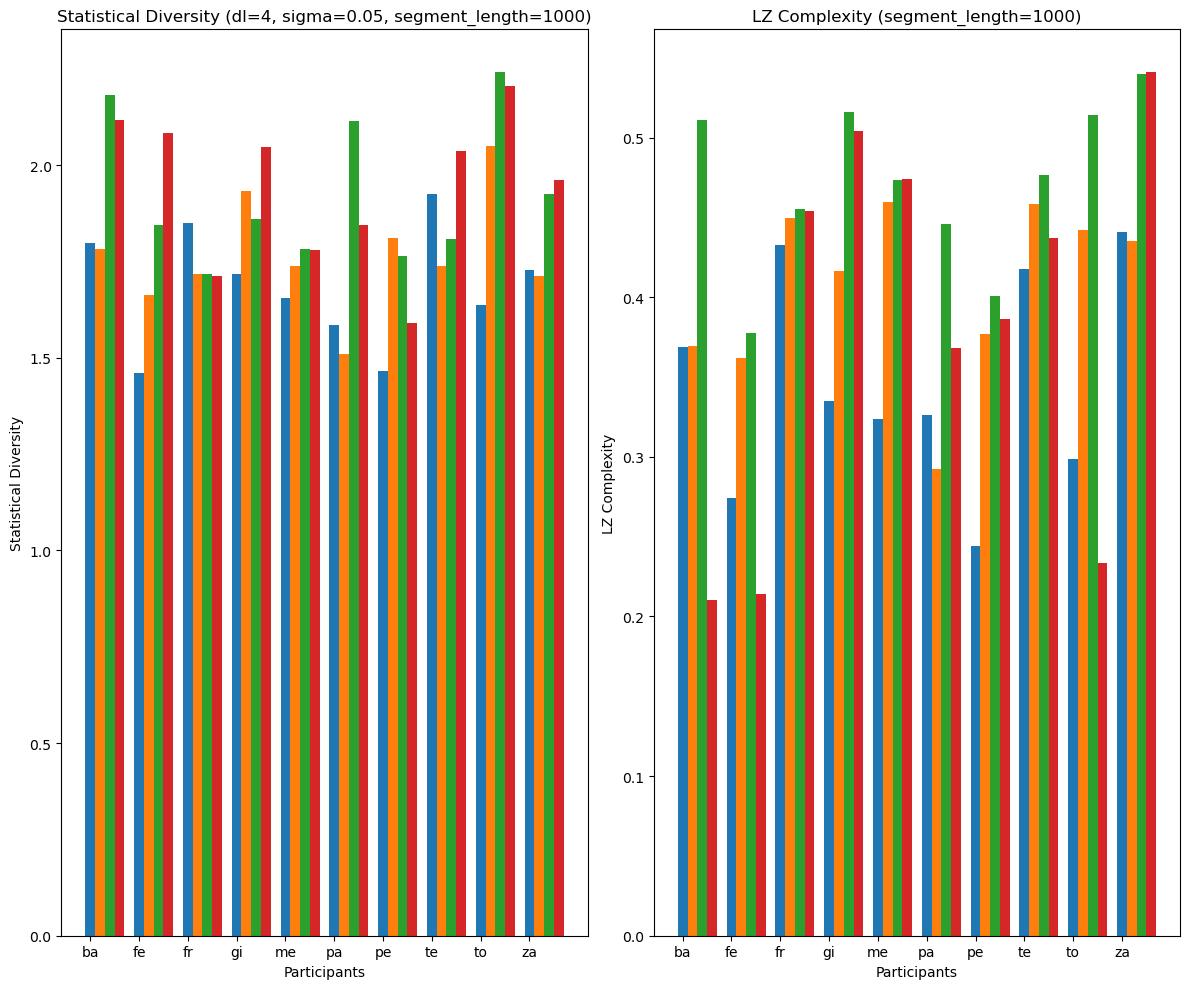

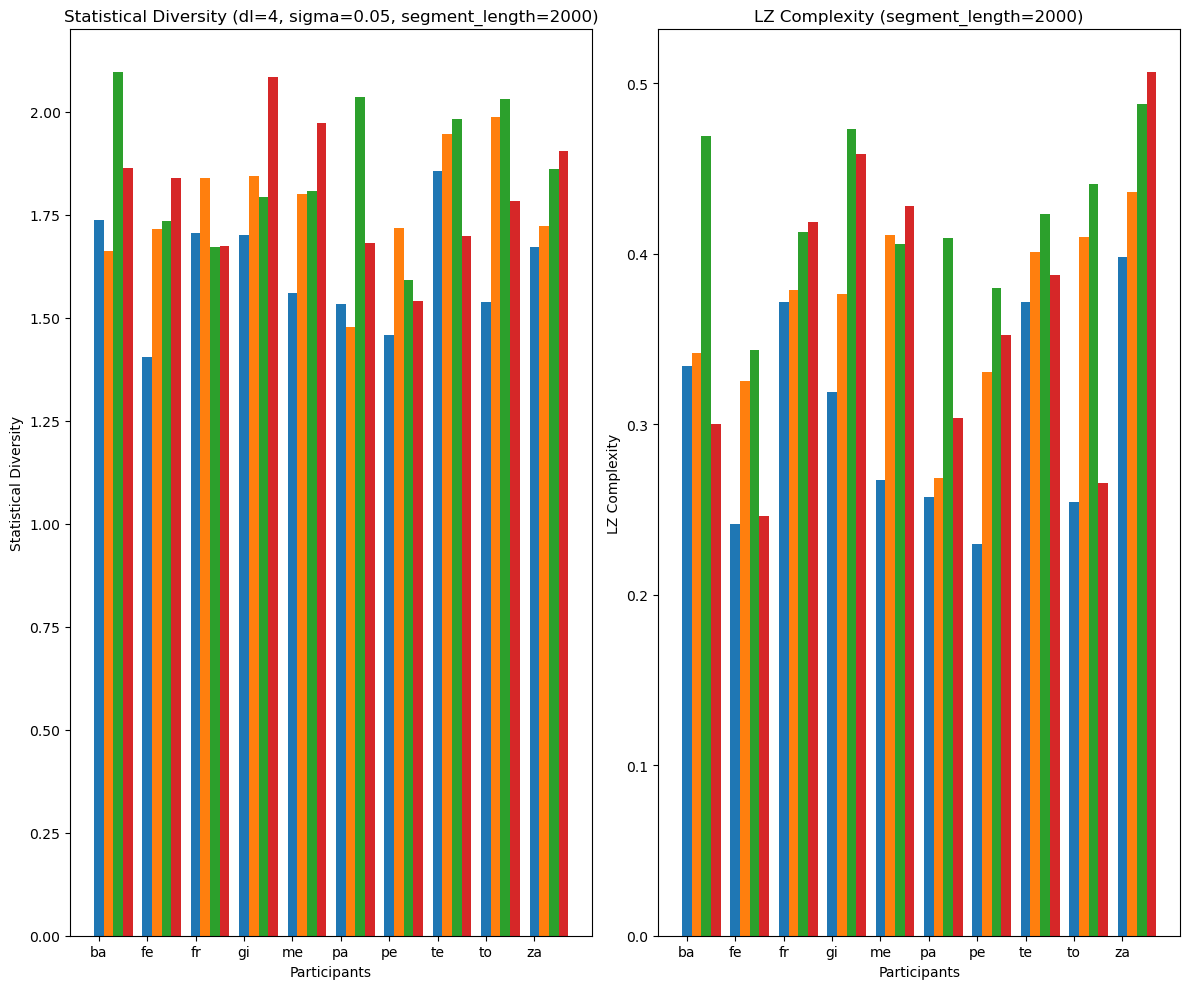

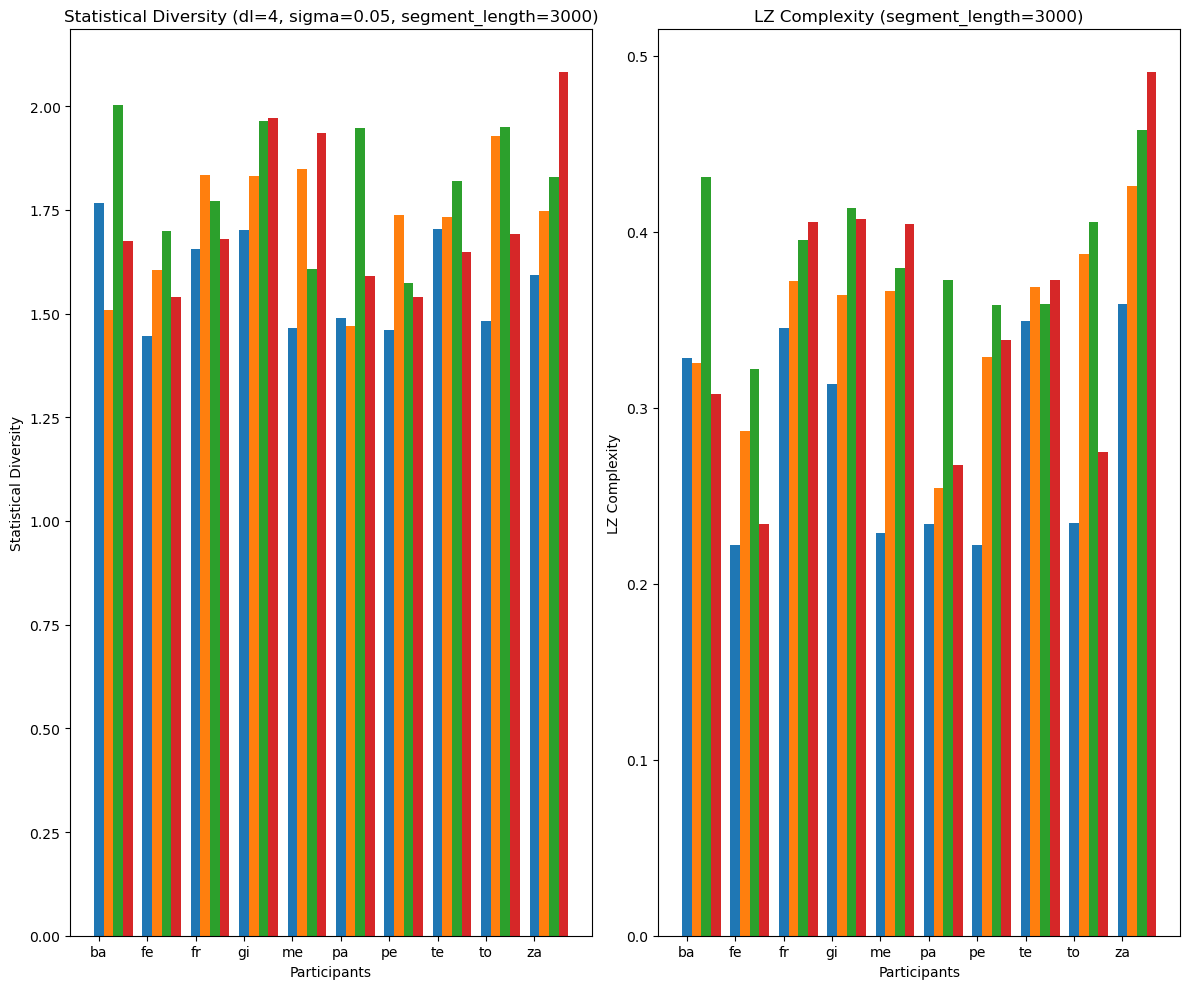

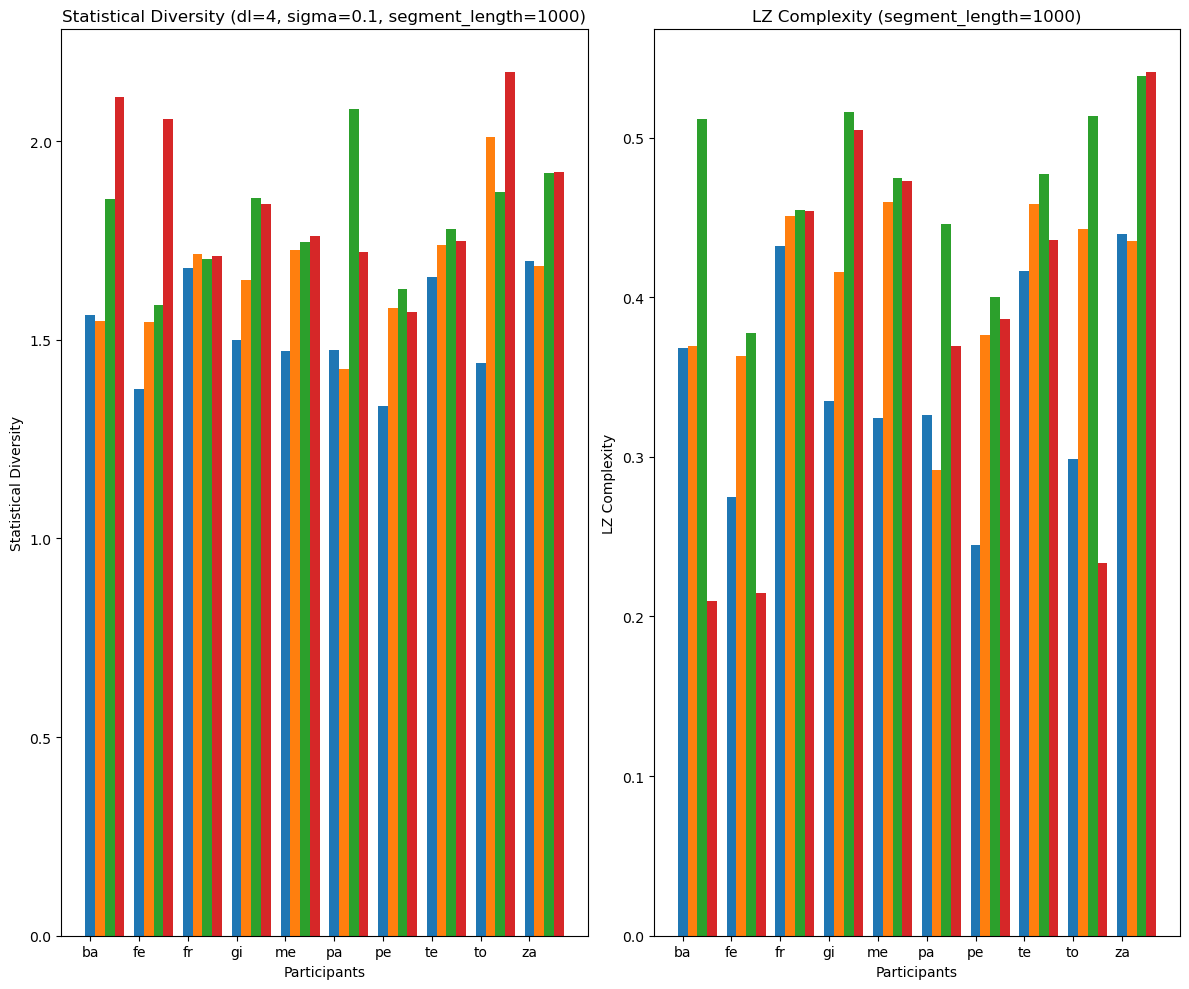

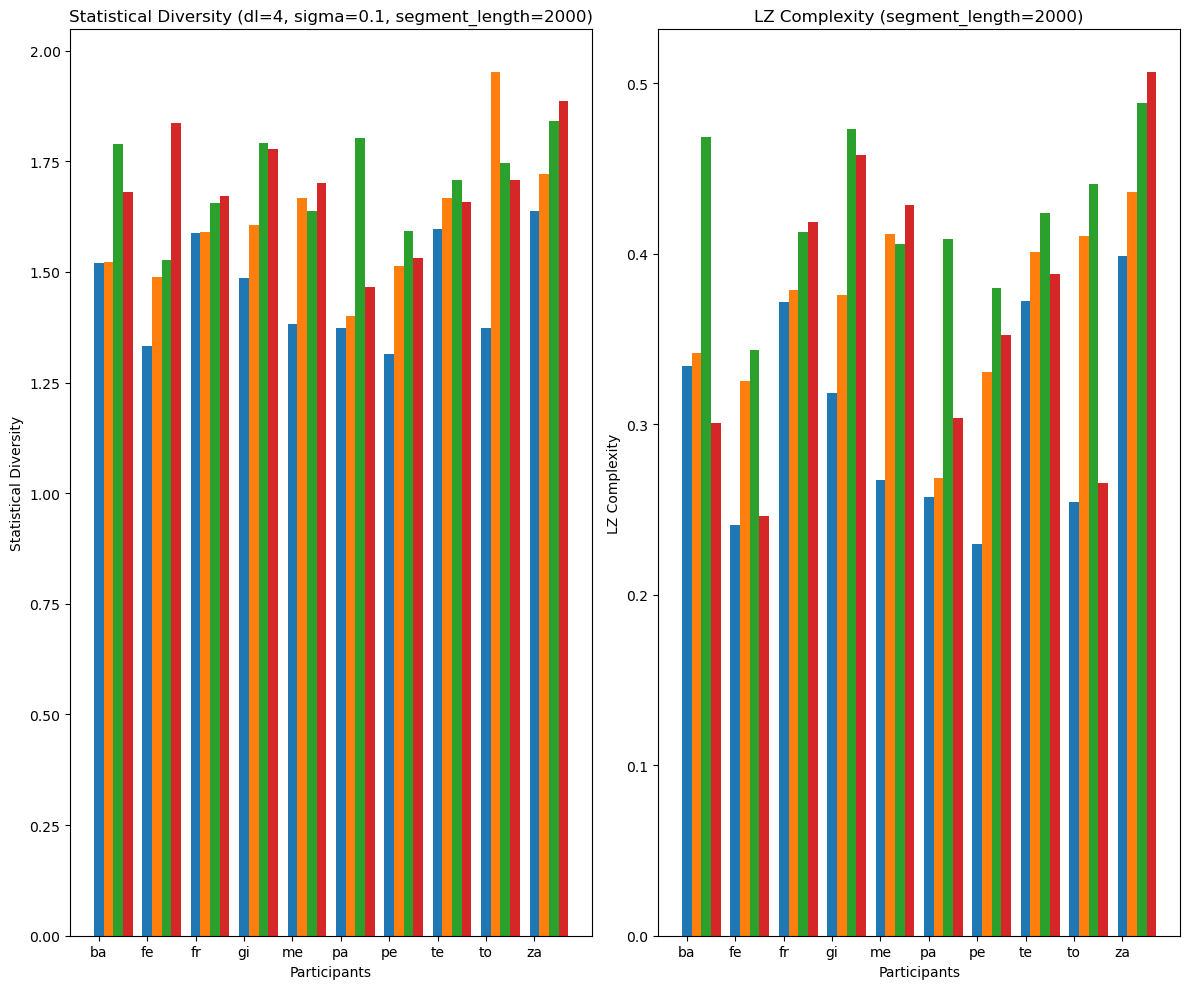

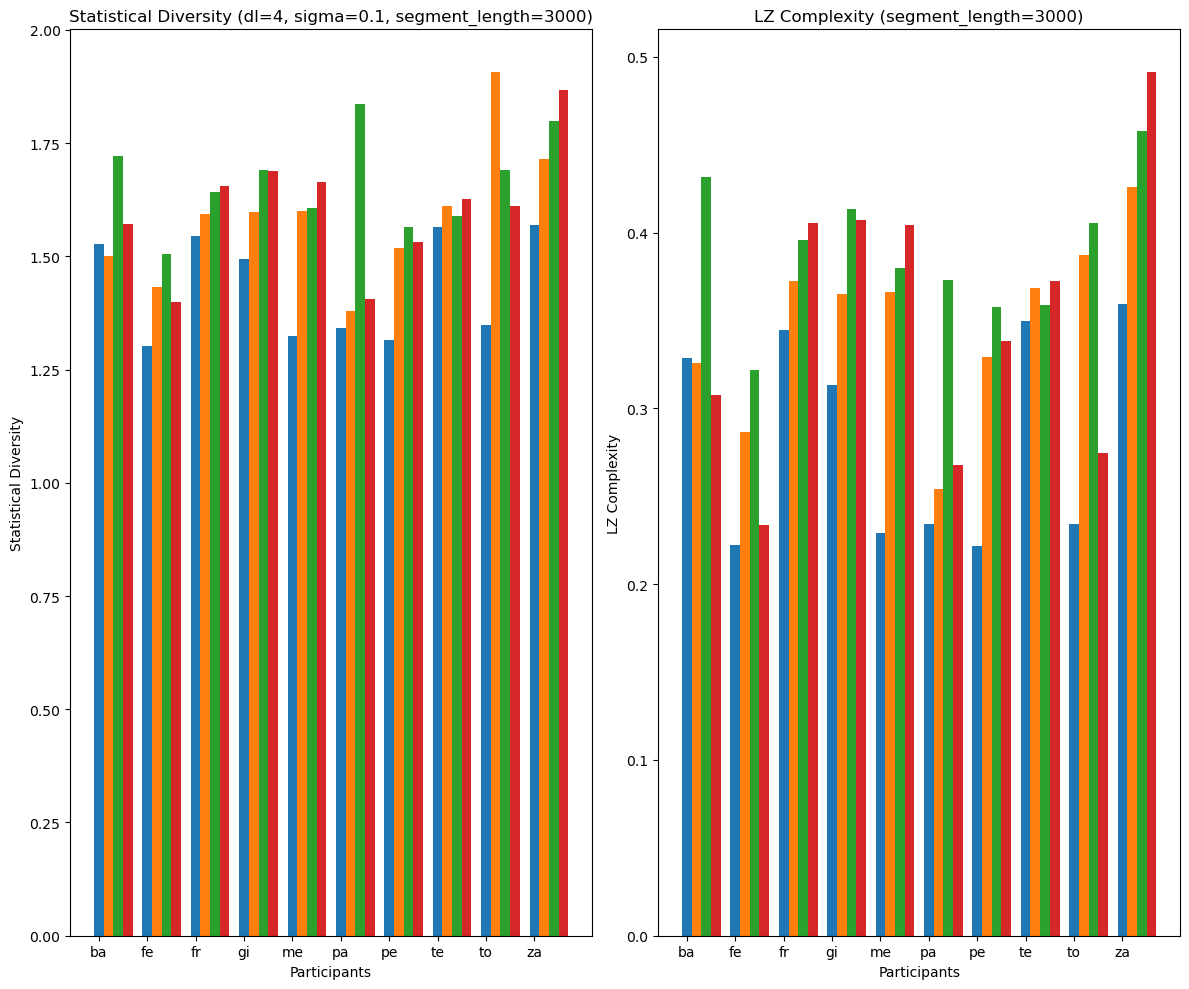

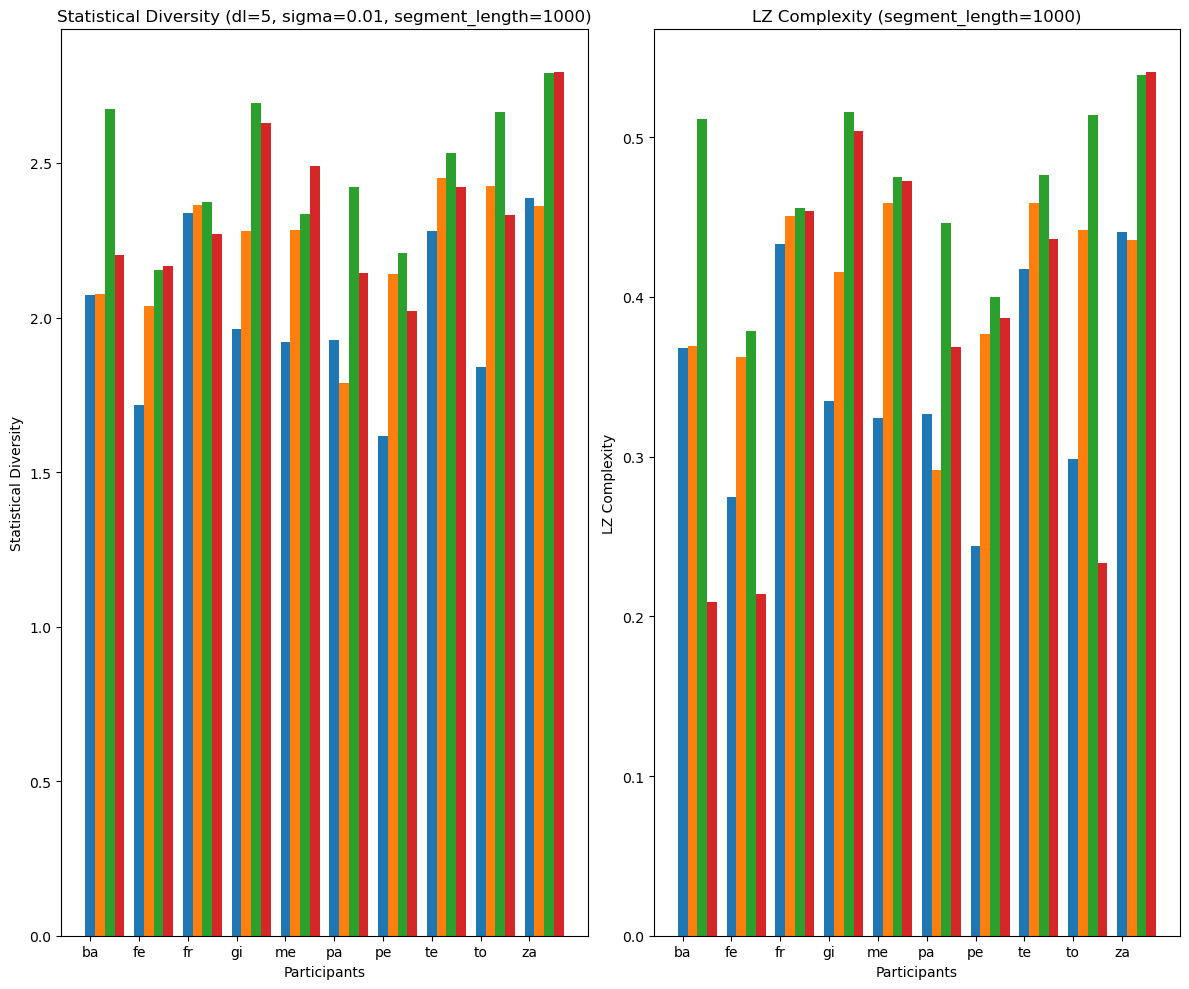

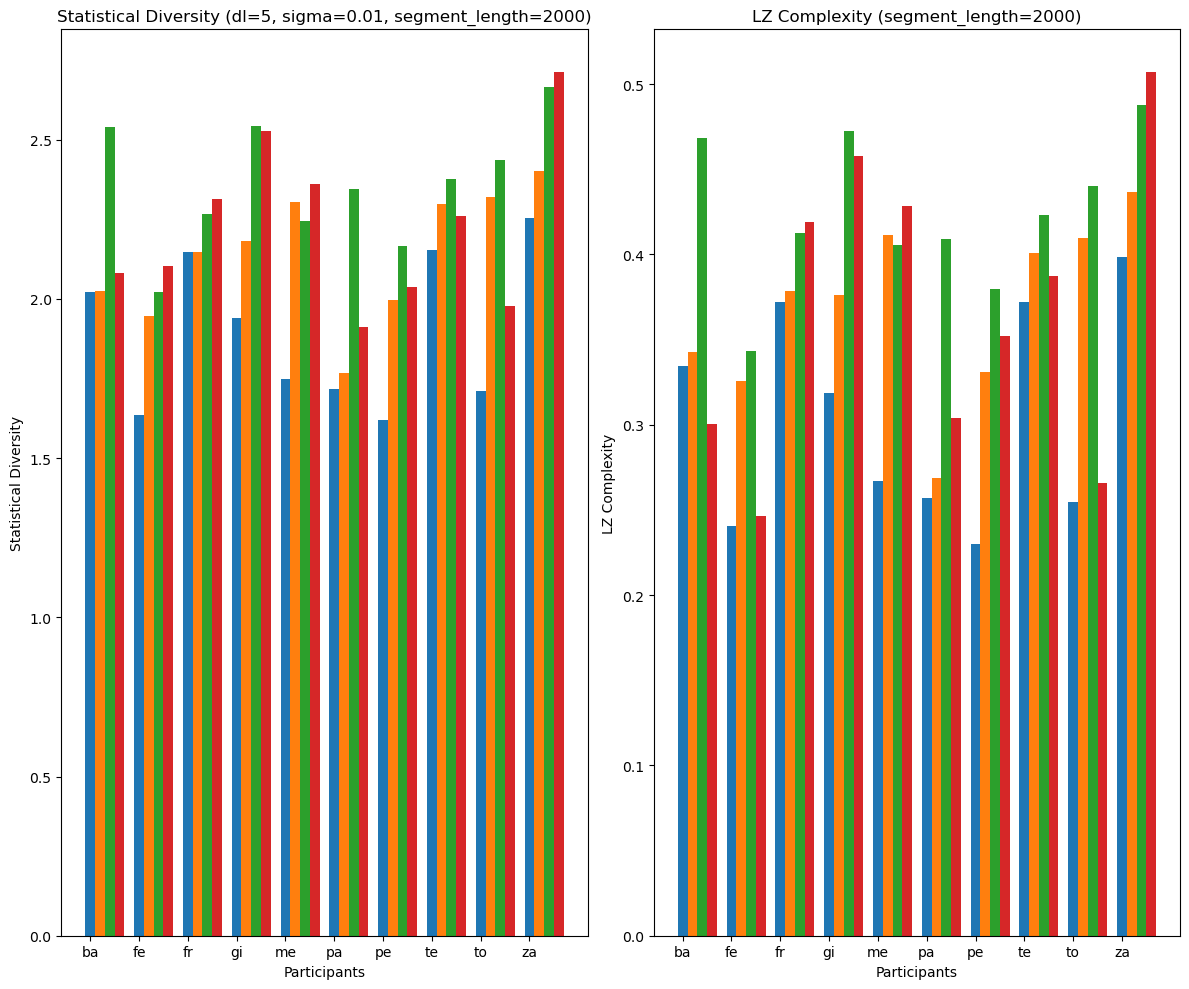

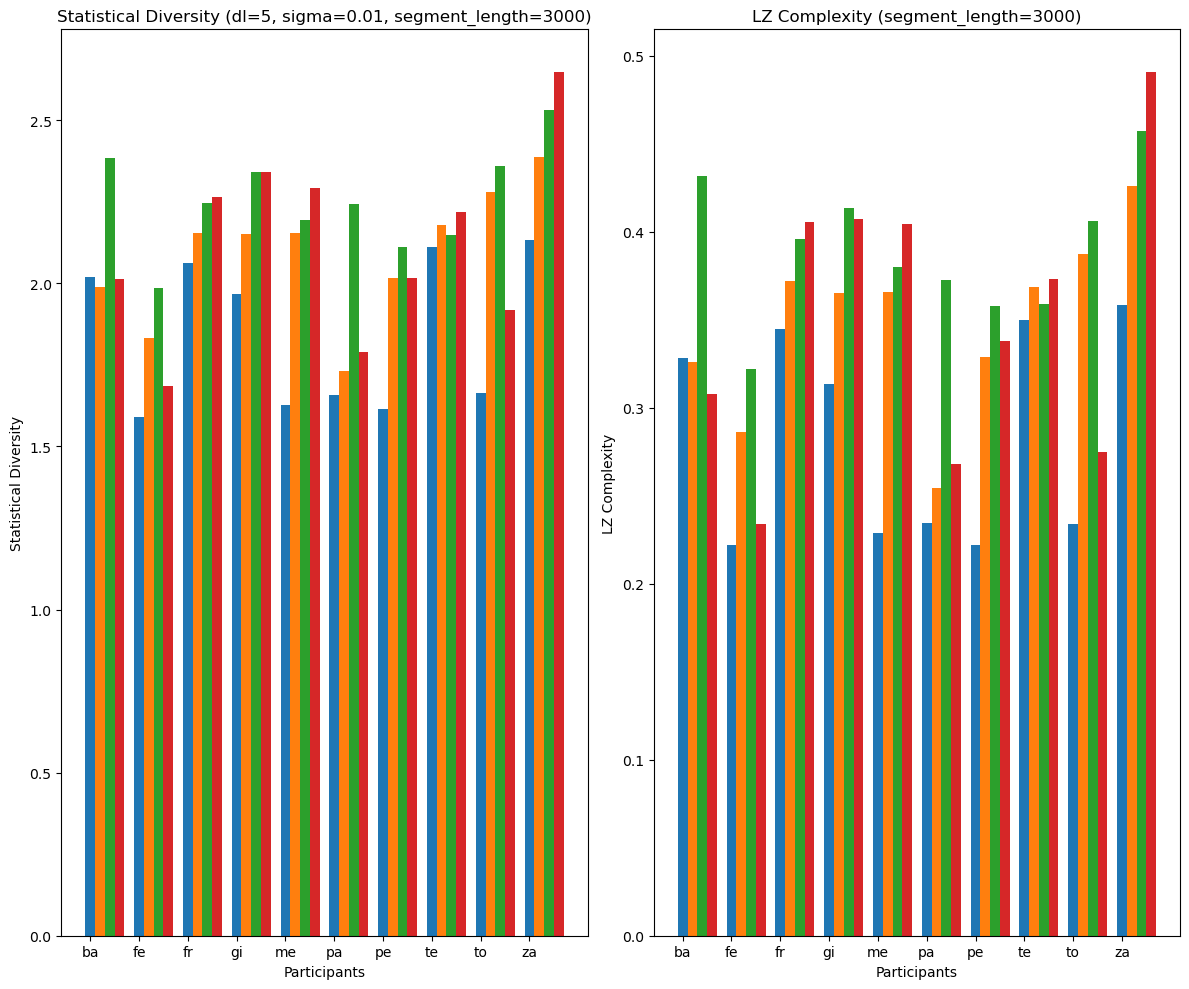

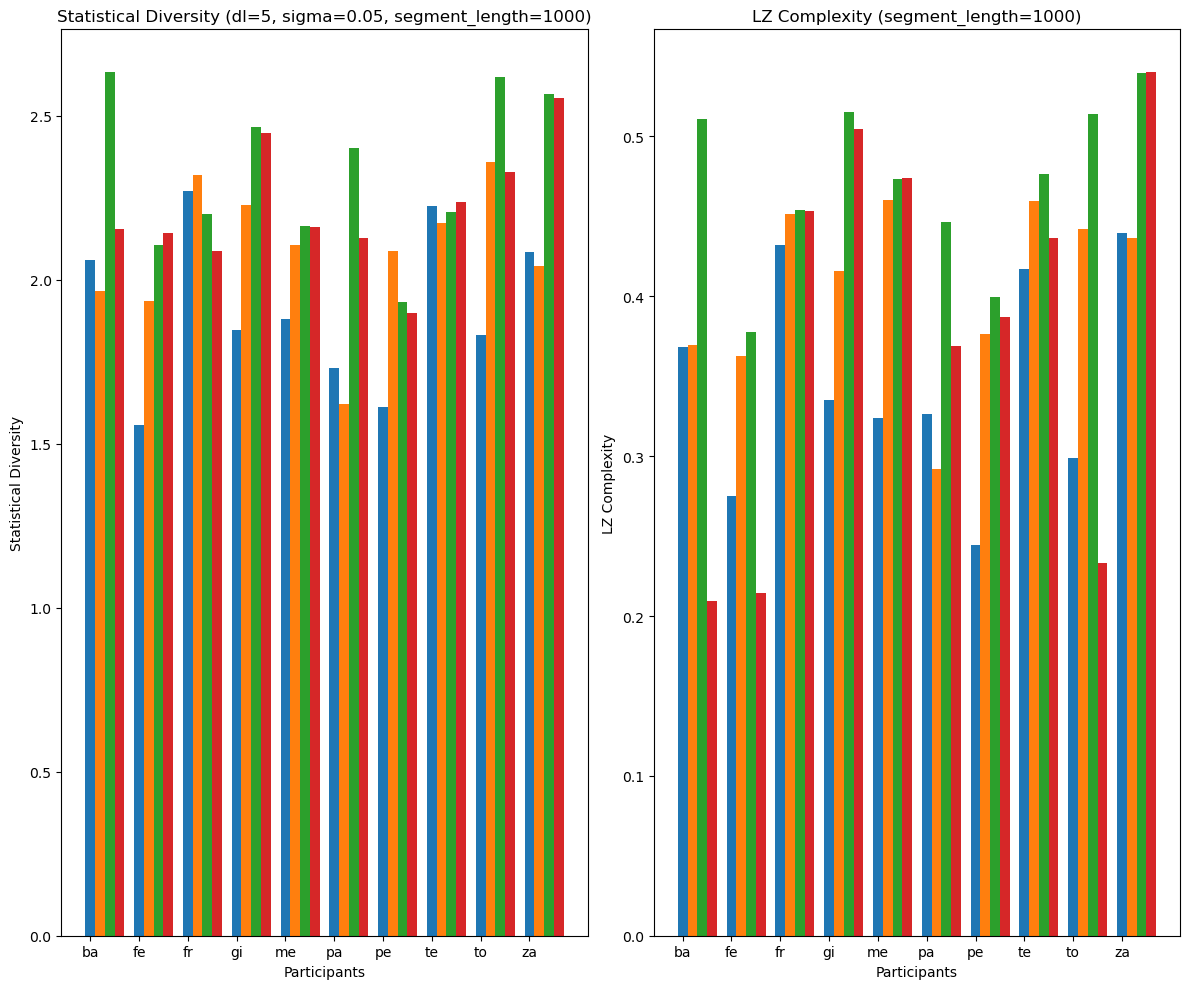

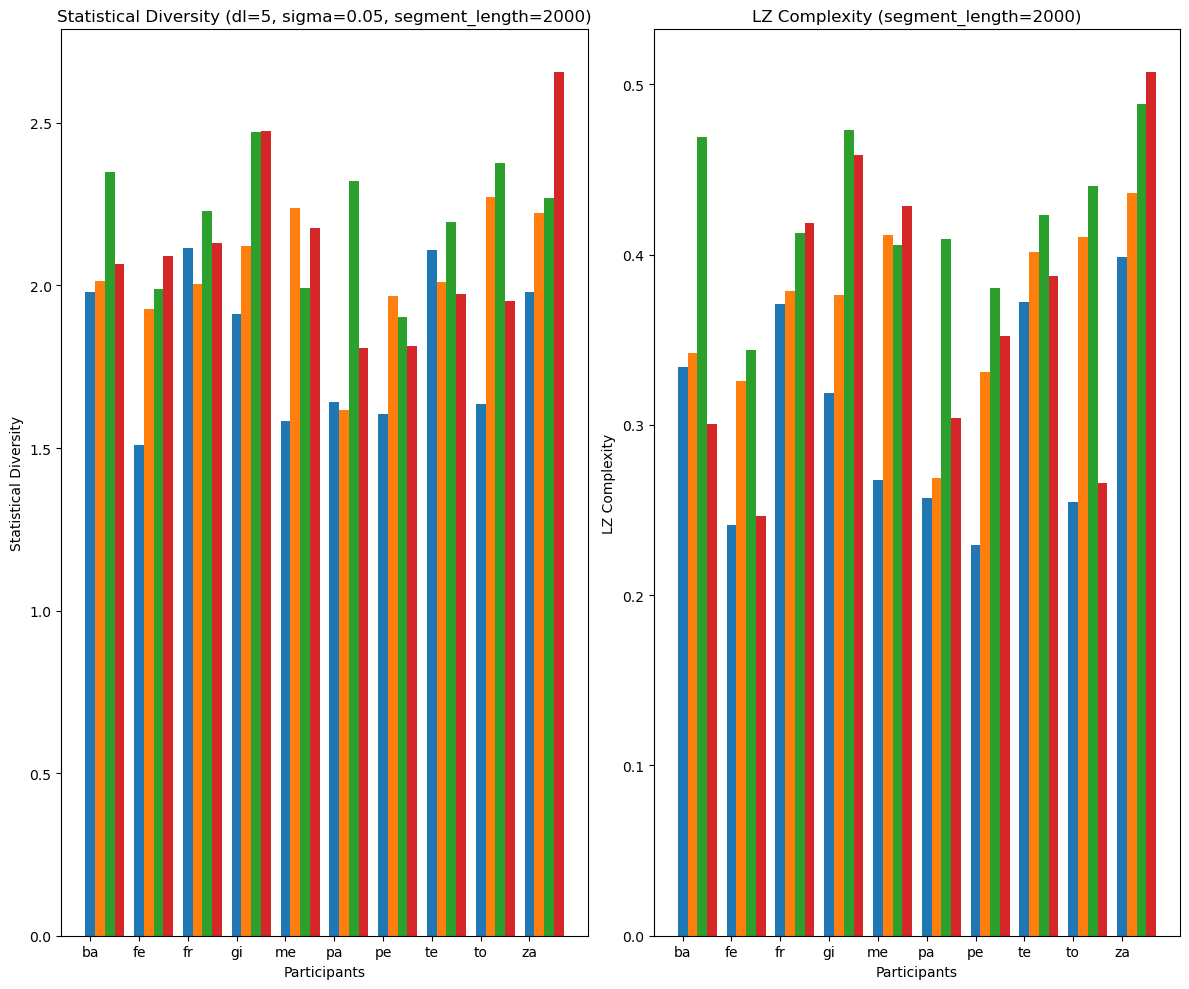

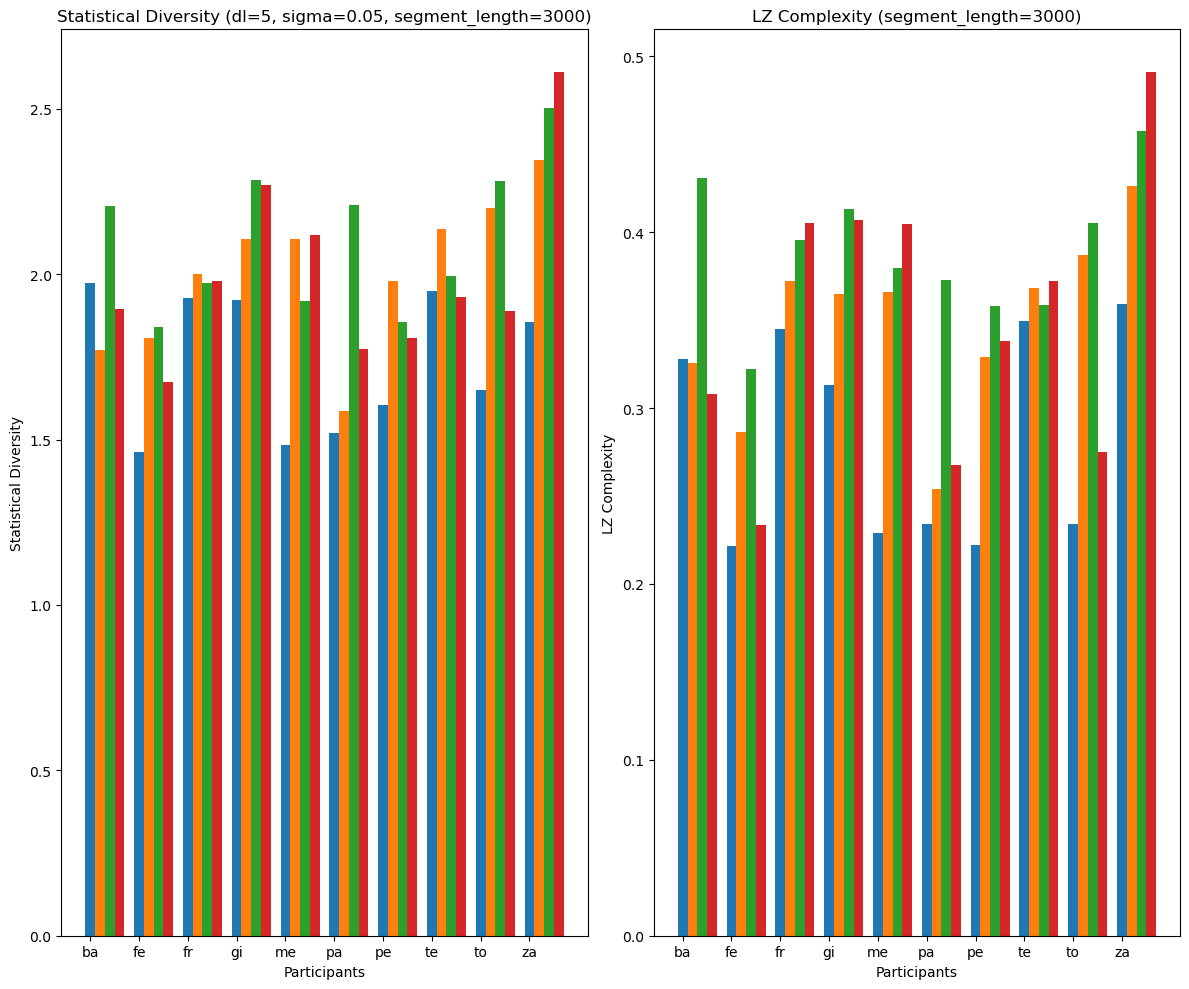

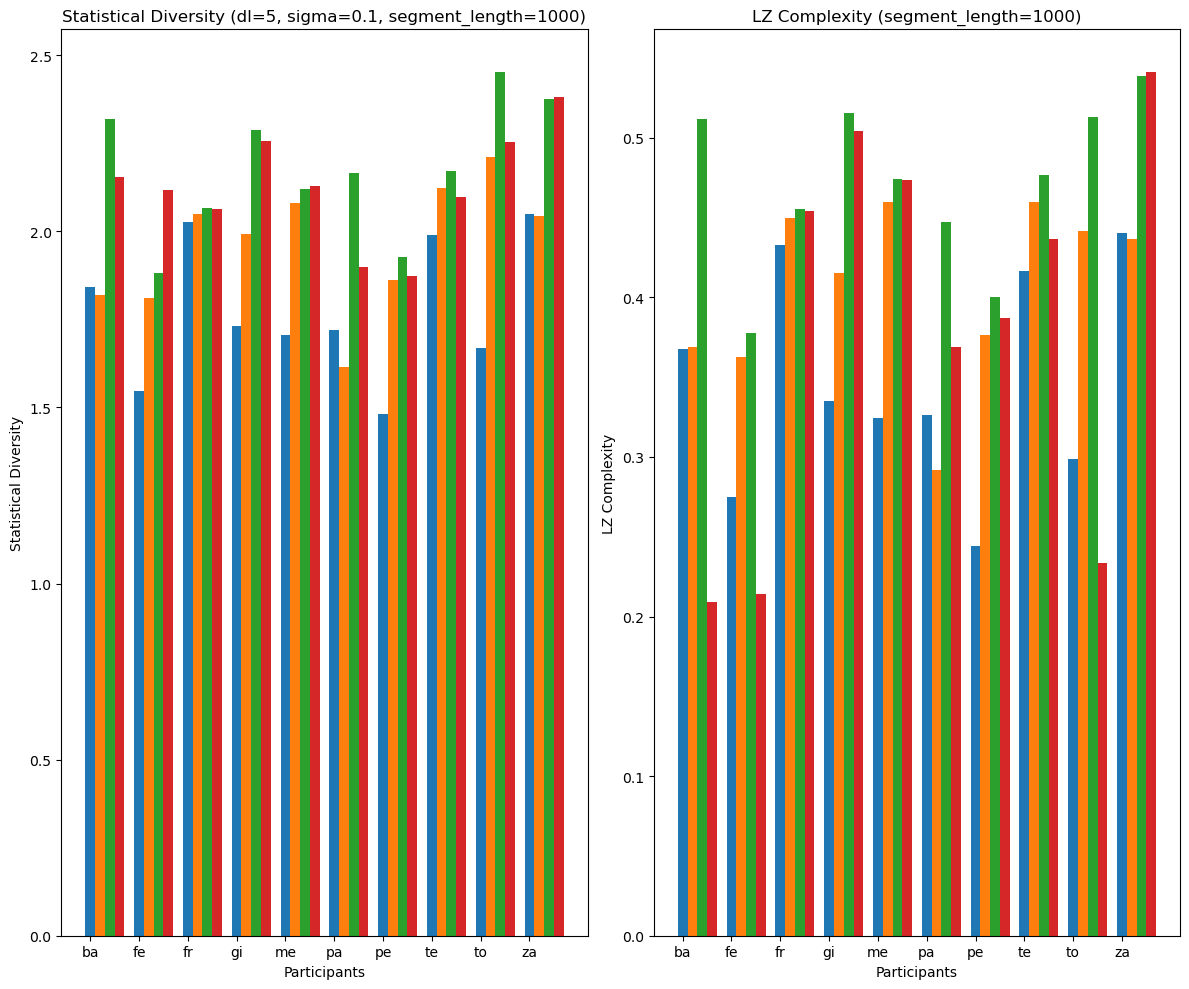

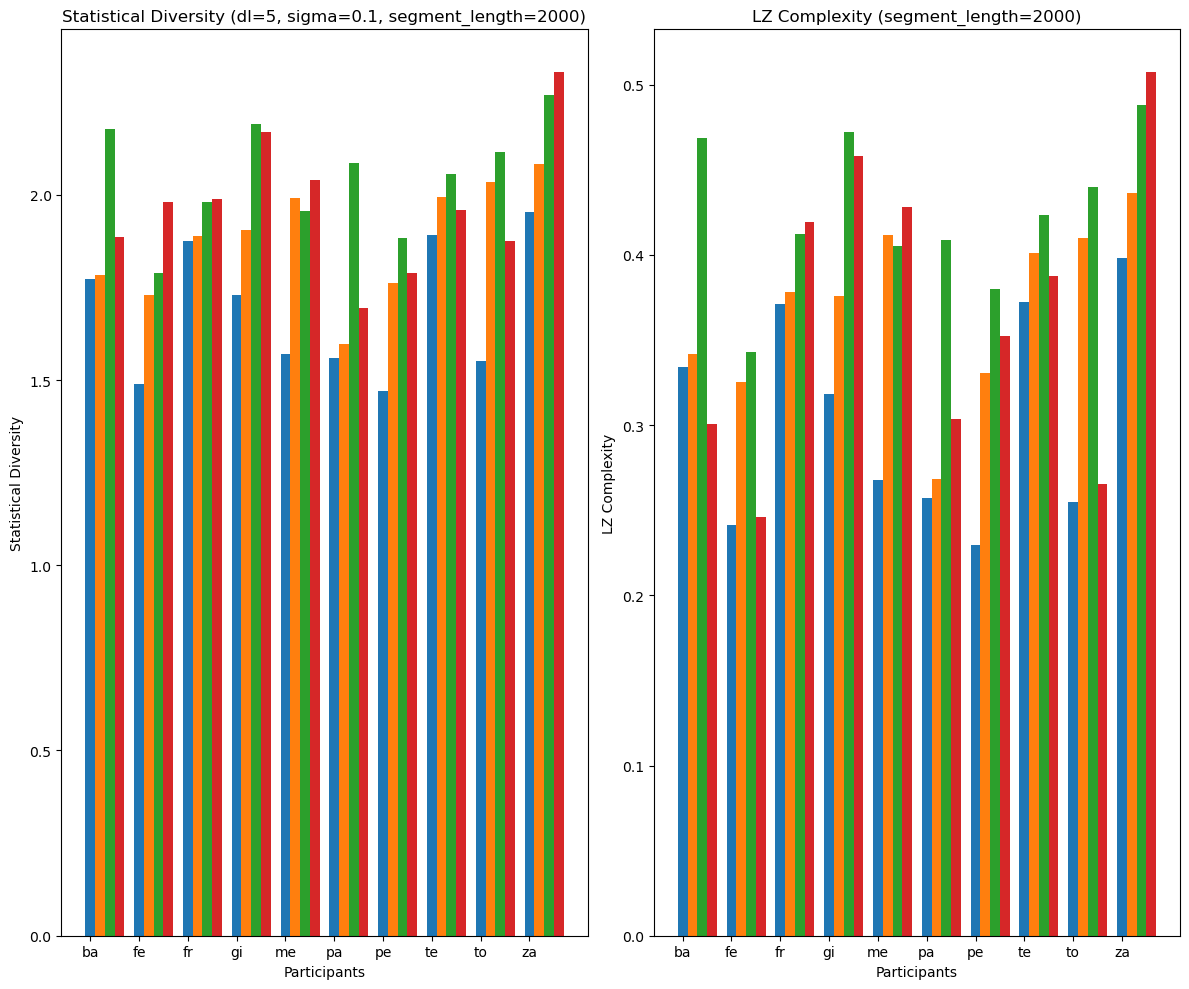

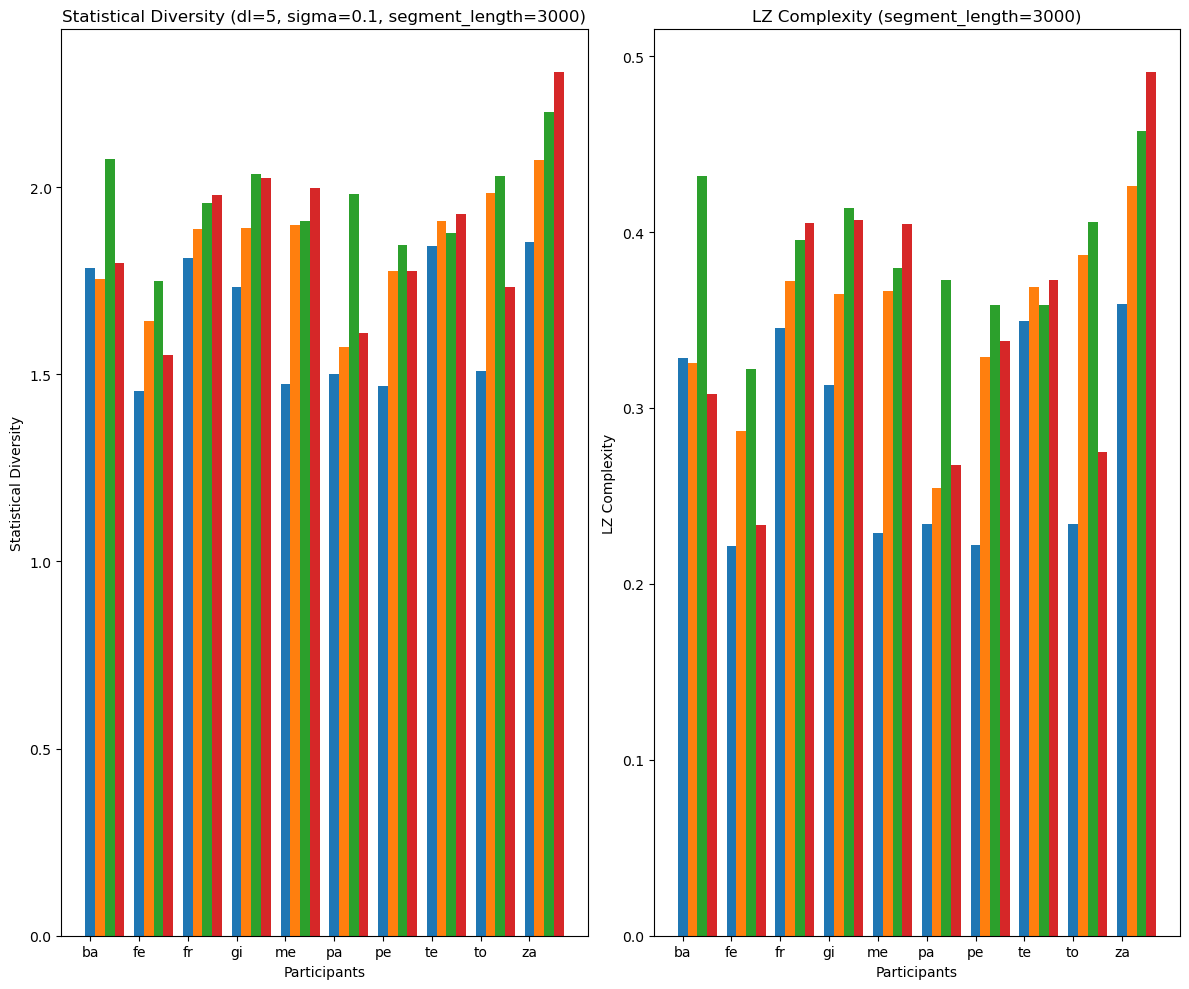

In [18]:
def visualize_results_varied_params(results):
    participants = list(results.keys())
    states = ['E', 'L', 'R', 'W']

    for dl in dls:
        for sigma in sigmas:
            for segment_length in segment_lengths:
                lz_complexities = {state: [] for state in states}
                stat_diversities = {state: [] for state in states}

                for participant in participants:
                    for state in states:
                        key = (dl, sigma, segment_length)
                        lz_complexity, stat_diversity = results[participant][state][key]
                        lz_complexities[state].append(lz_complexity)
                        stat_diversities[state].append(stat_diversity)

                plt.figure(figsize=(12, 10))

                plt.subplot(1, 2, 1)
                for idx, state in enumerate(states):
                    plt.bar([p + idx * 0.2 for p in range(len(participants))], 
                            stat_diversities[state], width=0.2, label=f"Stat Diversity {state}")
                plt.title(f'Statistical Diversity (dl={dl}, sigma={sigma}, segment_length={segment_length})')
                plt.xlabel('Participants')
                plt.ylabel('Statistical Diversity')
                plt.xticks(range(len(participants)), participants)
                #plt.legend()                

                plt.subplot(1, 2, 2)
                for idx, state in enumerate(states):
                    plt.bar([p + idx * 0.2 for p in range(len(participants))], 
                            lz_complexities[state], width=0.2, label=f"LZ Complexity {state}")
                plt.title(f'LZ Complexity (segment_length={segment_length})')
                plt.xlabel('Participants')
                plt.ylabel('LZ Complexity')
                plt.xticks(range(len(participants)), participants)
                #plt.legend()

                plt.tight_layout()
                plt.show()

visualize_results_varied_params(results_varied_params)

### **Statistical Analysis**
Perform statistical tests to assess the significance of the observed differences in complexity measures across states and participants.

#### 1. Organise Data

In [20]:
import pandas as pd

def create_dataframe(results, dls, sigmas, segment_lengths):
    data = []
    for participant, states in results.items():
        for state, params in states.items():
            for (dl, sigma, segment_length), (lz_complexity, stat_diversity) in params.items():
                data.append([participant, state, dl, sigma, segment_length, lz_complexity, stat_diversity])
    df = pd.DataFrame(data, columns=['Participant', 'State', 'dl', 'Sigma', 'SegmentLength', 'LZComplexity', 'StatDiversity'])
    return df

# Assuming `results_varied_params` is the dictionary containing all the results
df = create_dataframe(results_varied_params, dls, sigmas, segment_lengths)

In [21]:
df

,Participant,State,dl,Sigma,SegmentLength,LZComplexity,StatDiversity
0,ba,L,3,0.01,1000,0.368936,1.544820
1,ba,L,3,0.01,2000,0.342236,1.520748
2,ba,L,3,0.01,3000,0.325719,1.499153
3,ba,L,3,0.05,1000,0.369369,1.544820
4,ba,L,3,0.05,2000,0.342457,1.507579
...,...,...,...,...,...,...,...
1075,za,W,5,0.05,2000,0.506893,2.655126
1076,za,W,5,0.05,3000,0.490852,2.609565
1077,za,W,5,0.10,1000,0.540917,2.380179
1078,za,W,5,0.10,2000,0.507176,2.330213


#### Step 2: Perform ANOVA
We'll conduct ANOVA to compare the means of LZ complexity and statistical diversity across different sleep states.

In [23]:
# ANOVA for LZ Complexity
model_lz = ols('LZComplexity ~ C(State) + C(Participant) + C(dl) + C(Sigma) + C(SegmentLength)', data=df).fit()
anova_table_lz = sm.stats.anova_lm(model_lz, typ=2)
print("ANOVA Table for LZ Complexity")
print(anova_table_lz)

# ANOVA for Statistical Diversity
model_sd = ols('StatDiversity ~ C(State) + C(Participant) + C(dl) + C(Sigma) + C(SegmentLength)', data=df).fit()
anova_table_sd = sm.stats.anova_lm(model_sd, typ=2)
print("ANOVA Table for Statistical Diversity")
print(anova_table_sd)

ANOVA Table for LZ Complexity
                        sum_sq      df           F         PR(>F)
C(State)          1.852729e+00     3.0  336.847896  1.281316e-153
C(Participant)    2.613808e+00     9.0  158.407010  2.517307e-189
C(dl)             5.914638e-07     2.0    0.000161   9.998387e-01
C(Sigma)          6.817521e-08     2.0    0.000019   9.999814e-01
C(SegmentLength)  6.258858e-01     2.0  170.690065   5.366991e-65
Residual          1.945236e+00  1061.0         NaN            NaN
ANOVA Table for Statistical Diversity
                     sum_sq      df            F         PR(>F)
C(State)          12.911474     3.0   217.730180  4.785407e-110
C(Participant)     9.659262     9.0    54.295708   2.821615e-81
C(dl)             50.906203     2.0  1287.670551  1.619694e-284
C(Sigma)          10.967385     2.0   277.419602   1.221230e-97
C(SegmentLength)   3.626379     2.0    91.729120   1.798652e-37
Residual          20.972554  1061.0          NaN            NaN


#### Step 3: Post-hoc Test
If the ANOVA shows significant differences, we can perform Tukey's HSD post-hoc test.

In [25]:
# Tukey's HSD for LZ Complexity
tukey_lz = pairwise_tukeyhsd(endog=df['LZComplexity'], groups=df['State'], alpha=0.05)
print("Tukey's HSD for LZ Complexity")
print(tukey_lz.summary())

# Tukey's HSD for Statistical Diversity
tukey_sd = pairwise_tukeyhsd(endog=df['StatDiversity'], groups=df['State'], alpha=0.05)
print("\nTukey's HSD for Statistical Diversity")
print(tukey_sd.summary())

Tukey's HSD for LZ Complexity
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     E      L   0.0627    0.0  0.0474  0.0781   True
     E      R   0.1169    0.0  0.1015  0.1323   True
     E      W    0.055    0.0  0.0396  0.0703   True
     L      R   0.0542    0.0  0.0388  0.0695   True
     L      W  -0.0078 0.5645 -0.0231  0.0076  False
     R      W  -0.0619    0.0 -0.0773 -0.0465   True
----------------------------------------------------

Tukey's HSD for Statistical Diversity
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     E      L   0.1551    0.0  0.0889 0.2213   True
     E      R   0.2854    0.0  0.2192 0.3516   True
     E      W   0.2434    0.0  0.1772 0.3096   True
     L      R   0.1303    0.0  0.0641 0.1965   True
     L      W   0.0883 0.0035  0.0221

### Correlation Analysis

In [27]:
# Calculate Pearson correlation coefficient
correlation, p_value = stats.pearsonr(df['LZComplexity'], df['StatDiversity'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.42619039388538105
P-value: 6.786740871793892e-49


<Figure size 1000x600 with 0 Axes>

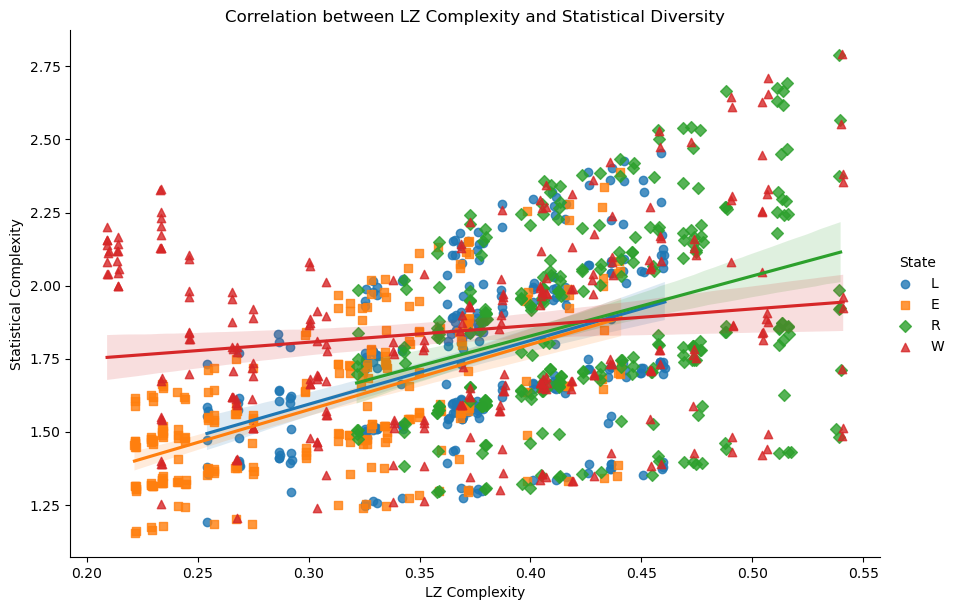

In [28]:
# Assuming df has a column 'State' indicating the state (W, R, L, E)
plt.figure(figsize=(10, 6))

# Scatter plot with regression line for each state
sns.lmplot(x='LZComplexity', y='StatDiversity', hue='State', data=df, height=6, aspect=1.5, markers=["o", "s", "D", "^"])

plt.title('Correlation between LZ Complexity and Statistical Diversity')
plt.xlabel('LZ Complexity')
plt.ylabel('Statistical Complexity')

file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\EEG_corr.png'
plt.show()

### **Participant-Specific Analysis**

#### A. **Individual Profiles**

To create complexity measure profiles for each participant across different sleep states, the LZ Complexity and Statistical Complexity will be calculated for each participant and each sleep state.

#### B. **Cluster Analysis**

To perform clustering, the complexity profiles will be used as features and clustering algorithms like K-means or hierarchical clustering will be applied.

#### 1. Calculate Complexity Measures

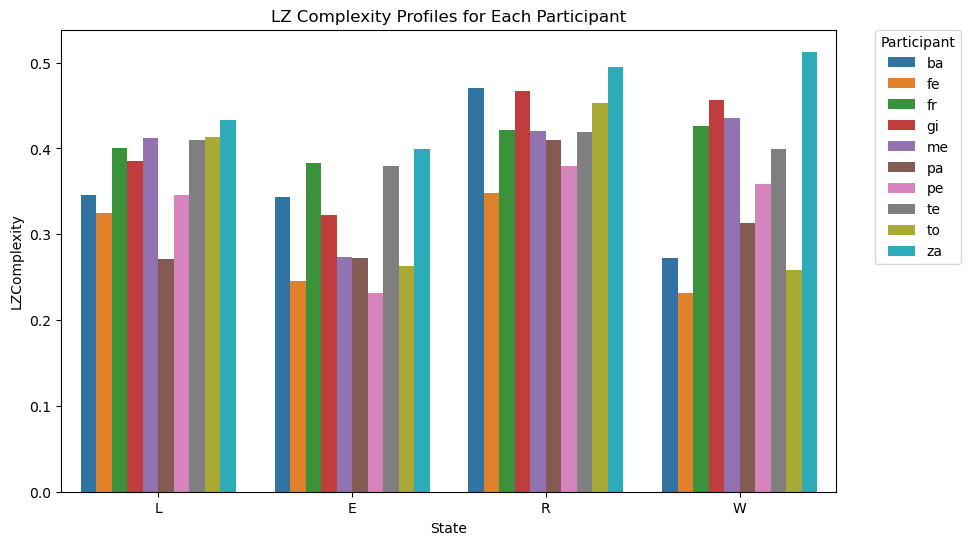

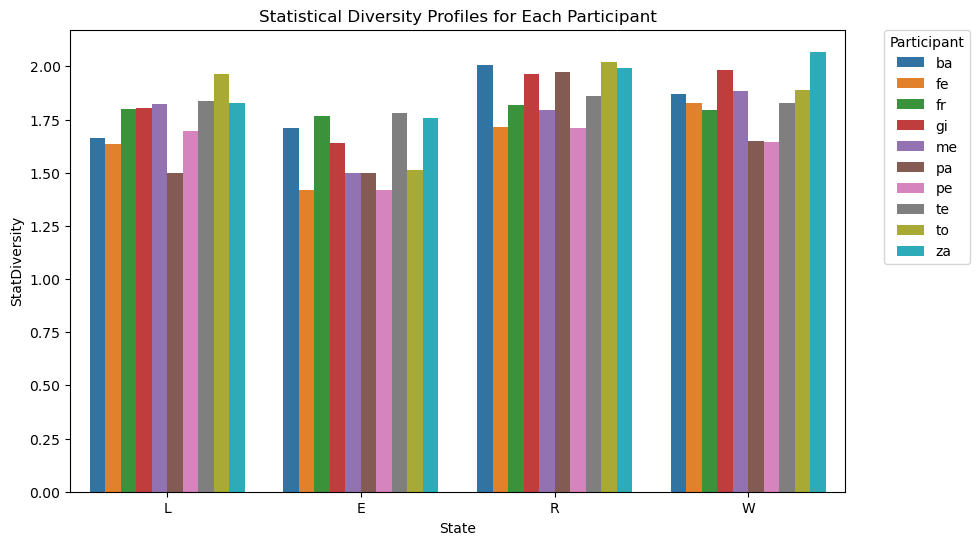

C:\Users\odans\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


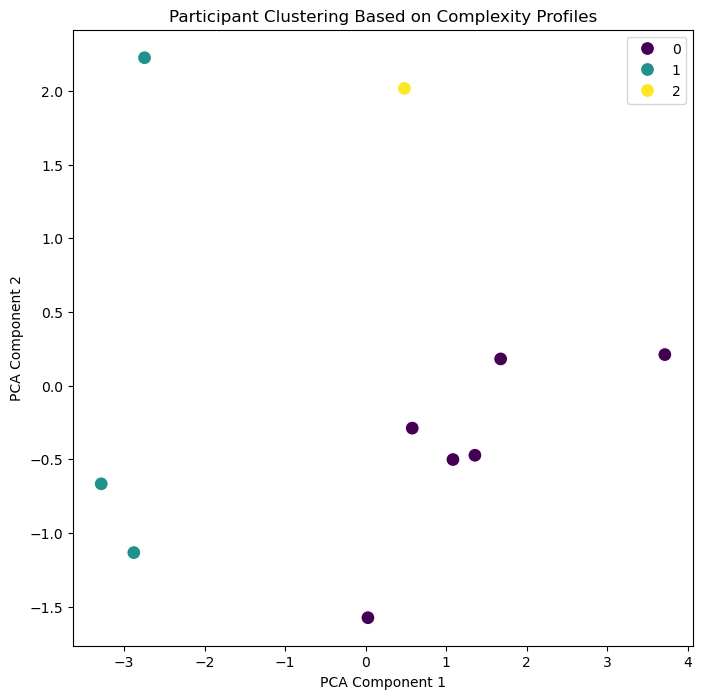

In [30]:
# Set the environment variable to avoid the memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"

# Plot and save LZ Complexity profiles as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='State', y='LZComplexity', hue='Participant', errorbar=None)
plt.title('LZ Complexity Profiles for Each Participant')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Participant')
plt.show()

# Plot and save Statistical Diversity profiles as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='State', y='StatDiversity', hue='Participant', errorbar=None)
plt.title('Statistical Diversity Profiles for Each Participant')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Participant')
plt.show()

# Aggregate the data by Participant and State
aggregated_df = df.groupby(['Participant', 'State'], as_index=False).mean()

# Now pivot the aggregated DataFrame
clustering_data = aggregated_df.pivot(index='Participant', columns='State', values=['LZComplexity', 'StatDiversity'])
clustering_data.columns = [f'{metric}_{state}' for metric, state in clustering_data.columns]

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clustering results to the DataFrame
clustering_data['Kmeans_Cluster'] = clusters

# Plot PCA results
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Participant Clustering Based on Complexity Profiles')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig(r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\PCA.png', bbox_inches='tight')
plt.show()

### Further Analysis

#### Step 1: Descriptive Statistics for Each Cluster

In [33]:
# Calculate descriptive statistics for each cluster
cluster_stats = clustering_data.groupby('Kmeans_Cluster').agg(['mean', 'std'])

# Print the descriptive statistics
print(cluster_stats)

               LZComplexity_E           LZComplexity_L            \
                         mean       std           mean       std   
Kmeans_Cluster                                                     
0                    0.336706  0.059327       0.408986  0.015594   
1                    0.250187  0.020603       0.314020  0.038077   
2                    0.343598       NaN       0.345695       NaN   

               LZComplexity_R           LZComplexity_W            \
                         mean       std           mean       std   
Kmeans_Cluster                                                     
0                    0.446061  0.031305       0.414614  0.085711   
1                    0.378791  0.030753       0.301256  0.064686   
2                    0.470568       NaN       0.272682       NaN   

               StatDiversity_E           StatDiversity_L            \
                          mean       std            mean       std   
Kmeans_Cluster                            

#### Step 2: Visualization of Cluster Profiles
Create box plots to visualize the distribution of complexity measures within each cluster:

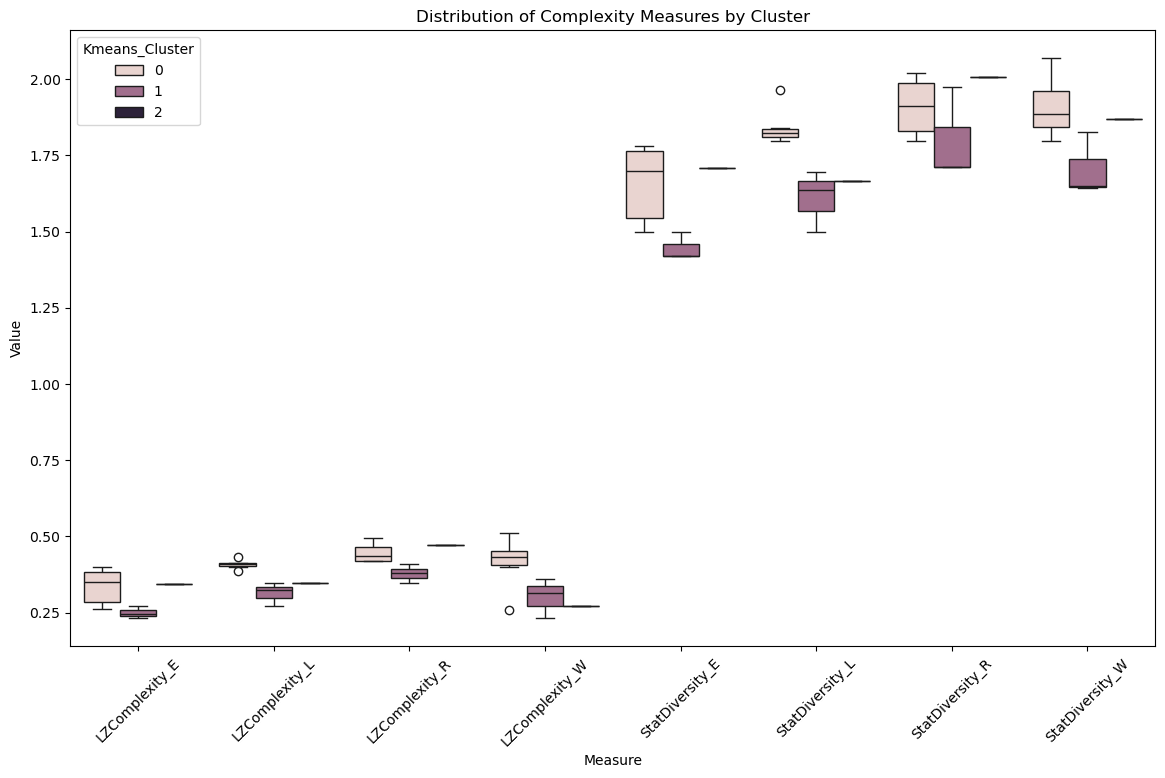

In [35]:
# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(clustering_data.reset_index(), id_vars=['Kmeans_Cluster'], value_vars=clustering_data.columns[:-1], var_name='Measure', value_name='Value')

# Box plot for each measure by cluster
plt.figure(figsize=(14, 8))
sns.boxplot(x='Measure', y='Value', hue='Kmeans_Cluster', data=melted_df)
plt.title('Distribution of Complexity Measures by Cluster')
plt.xticks(rotation=45)
plt.show()

#### Step 3: Cluster-wise Comparison
Perform ANOVA to compare the complexity measures across clusters:

In [37]:
# Perform ANOVA for each measure
anova_results = {}
for measure in clustering_data.columns[:-1]:
    clusters = [clustering_data[clustering_data['Kmeans_Cluster'] == c][measure] for c in clustering_data['Kmeans_Cluster'].unique()]
    anova_results[measure] = f_oneway(*clusters)

# Print ANOVA results
for measure, result in anova_results.items():
    print(f'ANOVA for {measure}: F={result.statistic}, p={result.pvalue}')

ANOVA for LZComplexity_E: F=3.0584603001056876, p=0.11102774677433726
ANOVA for LZComplexity_L: F=16.10507697213628, p=0.0024040761730191105
ANOVA for LZComplexity_R: F=5.685737017678939, p=0.03414594436730452
ANOVA for LZComplexity_W: F=2.7519976003373516, p=0.13127207373120114
ANOVA for StatDiversity_E: F=4.2134332632320675, p=0.0629319389954661
ANOVA for StatDiversity_L: F=10.2419299893615, p=0.008338176704403765
ANOVA for StatDiversity_R: F=1.5503475064075891, p=0.2770854602802055
ANOVA for StatDiversity_W: F=3.9422405824769378, p=0.07133048666446853


#### 2. Cluster Validation Using Hierarchical Clustering

C:\Users\odans\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


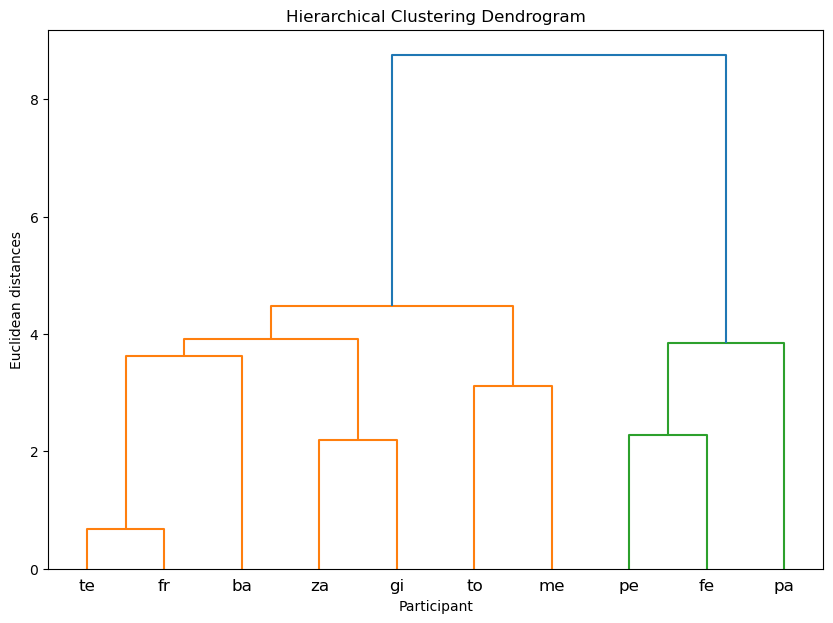

             KMeans Cluster  Hierarchical Cluster
Participant                                      
ba                        2                     0
fe                        1                     1
fr                        0                     0
gi                        0                     0
me                        0                     2
pa                        1                     1
pe                        1                     1
te                        0                     0
to                        0                     2
za                        0                     0


In [39]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(scaled_data)

# Add K-Means clustering results to the DataFrame with a descriptive name
clustering_data['KMeans Cluster'] = kmeans_clusters

# Perform hierarchical clustering (linkage)
linked = linkage(scaled_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=clustering_data.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Participant')
plt.ylabel('Euclidean distances')
plt.show()

# Agglomerative Clustering (Hierarchical Clustering)
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_clusters = hierarchical_clustering.fit_predict(scaled_data)

# Add hierarchical clustering results to the DataFrame
clustering_data['Hierarchical Cluster'] = hierarchical_clusters

# Compare the clusters
comparison = clustering_data[['KMeans Cluster', 'Hierarchical Cluster']]
print(comparison)